# Unsupervised Learning: Trade&Ahead

* Raid Mowla

**Marks: 60**

### Context

The stock market has consistently proven to be a good place to invest in and save for the future. There are a lot of compelling reasons to invest in stocks. It can help in fighting inflation, create wealth, and also provides some tax benefits. Good steady returns on investments over a long period of time can also grow a lot more than seems possible. Also, thanks to the power of compound interest, the earlier one starts investing, the larger the corpus one can have for retirement. Overall, investing in stocks can help meet life's financial aspirations.

It is important to maintain a diversified portfolio when investing in stocks in order to maximise earnings under any market condition. Having a diversified portfolio tends to yield higher returns and face lower risk by tempering potential losses when the market is down. It is often easy to get lost in a sea of financial metrics to analyze while determining the worth of a stock, and doing the same for a multitude of stocks to identify the right picks for an individual can be a tedious task. By doing a cluster analysis, one can identify stocks that exhibit similar characteristics and ones which exhibit minimum correlation. This will help investors better analyze stocks across different market segments and help protect against risks that could make the portfolio vulnerable to losses.


### Objective

Trade&Ahead is a financial consultancy firm who provide their customers with personalized investment strategies. They have hired you as a Data Scientist and provided you with data comprising stock price and some financial indicators for a few companies listed under the New York Stock Exchange. They have assigned you the tasks of analyzing the data, grouping the stocks based on the attributes provided, and sharing insights about the characteristics of each group.

### Data Dictionary

- Ticker Symbol: An abbreviation used to uniquely identify publicly traded shares of a particular stock on a particular stock market
- Company: Name of the company
- GICS Sector: The specific economic sector assigned to a company by the Global Industry Classification Standard (GICS) that best defines its business operations
- GICS Sub Industry: The specific sub-industry group assigned to a company by the Global Industry Classification Standard (GICS) that best defines its business operations
- Current Price: Current stock price in dollars
- Price Change: Percentage change in the stock price in 13 weeks
- Volatility: Standard deviation of the stock price over the past 13 weeks
- ROE: A measure of financial performance calculated by dividing net income by shareholders' equity (shareholders' equity is equal to a company's assets minus its debt)
- Cash Ratio: The ratio of a  company's total reserves of cash and cash equivalents to its total current liabilities
- Net Cash Flow: The difference between a company's cash inflows and outflows (in dollars)
- Net Income: Revenues minus expenses, interest, and taxes (in dollars)
- Earnings Per Share: Company's net profit divided by the number of common shares it has outstanding (in dollars)
- Estimated Shares Outstanding: Company's stock currently held by all its shareholders
- P/E Ratio: Ratio of the company's current stock price to the earnings per share 
- P/B Ratio: Ratio of the company's stock price per share by its book value per share (book value of a company is the net difference between that company's total assets and total liabilities)

## Importing necessary libraries and data

In [119]:
# To supress warnings
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist, pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to perform PCA
from sklearn.decomposition import PCA

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

#format numeric data for easier readability
pd.set_option(
    "display.float_format", lambda x: "%.2f" % x
)  # to display numbers rounded off to 2 decimal places

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

In [120]:

#function to print labeled barplots
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=12)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="viridis",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  #width
        y = p.get_height()  # height 

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )


In [121]:

def histogram_boxplot(data, feature, figsize=(16, 6), kde=False, bins=None, hue=None):
    """
    Combines boxplot and histogram

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (16,6))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True,
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter",
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )

In [122]:
# reading the csv file
trd = pd.read_csv('stock_data.csv')

In [123]:
#creating a copy of the file
td = trd.copy()

* Displaying few rows of the stock dataset

In [124]:
# let's view a sample of the data
td.sample(n=10, random_state= 1)

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
102,DVN,Devon Energy Corp.,Energy,Oil & Gas Exploration & Production,32.00,-15.48,2.92,205,70,830000000,-14454000000,-35.55,406582278.50,93.09,1.79
125,FB,Facebook,Information Technology,Internet Software & Services,104.66,16.22,1.32,8,958,592000000,3669000000,1.31,2800763359.00,79.89,5.88
11,AIV,Apartment Investment & Mgmt,Real Estate,REITs,40.03,7.58,1.16,15,47,21818000,248710000,1.52,163625000.00,26.34,-1.27
248,PG,Procter & Gamble,Consumer Staples,Personal Products,79.41,10.66,0.81,17,129,160383000,636056000,3.28,491391569.00,24.07,-2.26
238,OXY,Occidental Petroleum,Energy,Oil & Gas Exploration & Production,67.61,0.87,1.59,32,64,-588000000,-7829000000,-10.23,765298142.70,93.09,3.35
336,YUM,Yum! Brands Inc,Consumer Discretionary,Restaurants,52.52,-8.70,1.48,142,27,159000000,1293000000,2.97,435353535.40,17.68,-3.84
112,EQT,EQT Corporation,Energy,Oil & Gas Exploration & Production,52.13,-21.25,2.36,2,201,523803000,85171000,0.56,152091071.40,93.09,9.57
147,HAL,Halliburton Co.,Energy,Oil & Gas Equipment & Services,34.04,-5.10,1.97,4,189,7786000000,-671000000,-0.79,849367088.60,93.09,17.35
89,DFS,Discover Financial Services,Financials,Consumer Finance,53.62,3.65,1.16,20,99,2288000000,2297000000,5.14,446887159.50,10.43,-0.38
173,IVZ,Invesco Ltd.,Financials,Asset Management & Custody Banks,33.48,7.07,1.58,12,67,412000000,968100000,2.26,428362831.90,14.81,4.22


* Size of the dataset

In [125]:
td.shape

(340, 15)

* The set has 340 rows and 15 columns.


* Data type summary

In [126]:
td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticker Symbol                 340 non-null    object 
 1   Security                      340 non-null    object 
 2   GICS Sector                   340 non-null    object 
 3   GICS Sub Industry             340 non-null    object 
 4   Current Price                 340 non-null    float64
 5   Price Change                  340 non-null    float64
 6   Volatility                    340 non-null    float64
 7   ROE                           340 non-null    int64  
 8   Cash Ratio                    340 non-null    int64  
 9   Net Cash Flow                 340 non-null    int64  
 10  Net Income                    340 non-null    int64  
 11  Earnings Per Share            340 non-null    float64
 12  Estimated Shares Outstanding  340 non-null    float64
 13  P/E R

## Data Overview

- Observations
- Sanity checks

* Null Values check

In [127]:
td.isnull().sum()

Ticker Symbol                   0
Security                        0
GICS Sector                     0
GICS Sub Industry               0
Current Price                   0
Price Change                    0
Volatility                      0
ROE                             0
Cash Ratio                      0
Net Cash Flow                   0
Net Income                      0
Earnings Per Share              0
Estimated Shares Outstanding    0
P/E Ratio                       0
P/B Ratio                       0
dtype: int64

* We can see that we have no null-values which is a great start for us.

* Duplicated Values check

In [128]:
td.duplicated().sum()

0

* We also have no duplicated values too.

In [129]:
td.describe().T       #will generate a statistical summary of the dataset in a transpose form

,count,mean,std,min,25%,50%,75%,max
Current Price,340.00,80.86,98.06,4.50,38.55,59.70,92.88,1274.95
Price Change,340.00,4.08,12.01,-47.13,-0.94,4.82,10.70,55.05
Volatility,340.00,1.53,0.59,0.73,1.13,1.39,1.70,4.58
ROE,340.00,39.60,96.55,1.00,9.75,15.00,27.00,917.00
Cash Ratio,340.00,70.02,90.42,0.00,18.00,47.00,99.00,958.00
Net Cash Flow,340.00,55537620.59,1946365312.18,-11208000000.00,-193906500.00,2098000.00,169810750.00,20764000000.00
Net Income,340.00,1494384602.94,3940150279.33,-23528000000.00,352301250.00,707336000.00,1899000000.00,24442000000.00
Earnings Per Share,340.00,2.78,6.59,-61.20,1.56,2.90,4.62,50.09
Estimated Shares Outstanding,340.00,577028337.75,845849595.42,27672156.86,158848216.10,309675137.80,573117457.32,6159292035.00
P/E Ratio,340.00,32.61,44.35,2.94,15.04,20.82,31.76,528.04


We can see that the mean of the 'Current Price' is $80.86. The  mean volatility is 1.53%, the mean cash ratio is 70.02% which is pretty good for any company. The mean P/E ratio we can also see that is 32.61.

In [130]:
td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticker Symbol                 340 non-null    object 
 1   Security                      340 non-null    object 
 2   GICS Sector                   340 non-null    object 
 3   GICS Sub Industry             340 non-null    object 
 4   Current Price                 340 non-null    float64
 5   Price Change                  340 non-null    float64
 6   Volatility                    340 non-null    float64
 7   ROE                           340 non-null    int64  
 8   Cash Ratio                    340 non-null    int64  
 9   Net Cash Flow                 340 non-null    int64  
 10  Net Income                    340 non-null    int64  
 11  Earnings Per Share            340 non-null    float64
 12  Estimated Shares Outstanding  340 non-null    float64
 13  P/E R

* Converting all the data-type 'object' to category for predictive purposes

In [131]:
for i in td.columns[td.dtypes=='object']:
    td[i] = td[i].astype('category')

* Now, lets check the new data-types

In [132]:
td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Ticker Symbol                 340 non-null    category
 1   Security                      340 non-null    category
 2   GICS Sector                   340 non-null    category
 3   GICS Sub Industry             340 non-null    category
 4   Current Price                 340 non-null    float64 
 5   Price Change                  340 non-null    float64 
 6   Volatility                    340 non-null    float64 
 7   ROE                           340 non-null    int64   
 8   Cash Ratio                    340 non-null    int64   
 9   Net Cash Flow                 340 non-null    int64   
 10  Net Income                    340 non-null    int64   
 11  Earnings Per Share            340 non-null    float64 
 12  Estimated Shares Outstanding  340 non-null    floa

In [133]:
td['Ticker Symbol'].nunique()

340

The number of unique values on 'Ticker Symbol' is 340

Since, 'Ticker Symbol' is actually a unique value column so we will drop it.

In [134]:
td.drop("Ticker Symbol", axis = 1 , inplace = True)

In [135]:
td.info()           #re-checking the updated dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Security                      340 non-null    category
 1   GICS Sector                   340 non-null    category
 2   GICS Sub Industry             340 non-null    category
 3   Current Price                 340 non-null    float64 
 4   Price Change                  340 non-null    float64 
 5   Volatility                    340 non-null    float64 
 6   ROE                           340 non-null    int64   
 7   Cash Ratio                    340 non-null    int64   
 8   Net Cash Flow                 340 non-null    int64   
 9   Net Income                    340 non-null    int64   
 10  Earnings Per Share            340 non-null    float64 
 11  Estimated Shares Outstanding  340 non-null    float64 
 12  P/E Ratio                     340 non-null    floa

We can see that 'Ticker Symbol' has been sucesfully removed from our dataset. And, also the 'object' data types has been converted to category too.

## Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

**Questions**:

1. What does the distribution of stock prices look like?
2. The stocks of which economic sector have seen the maximum price increase on average?
3. How are the different variables correlated with each other?
4. Cash ratio provides a measure of a company's ability to cover its short-term obligations using only cash and cash equivalents. How does the average cash ratio vary across economic sectors?
5. P/E ratios can help determine the relative value of a company's shares as they signify the amount of money an investor is willing to invest in a single share of a company per dollar of its earnings. How does the P/E ratio vary, on average, across economic sectors?

* Current Price

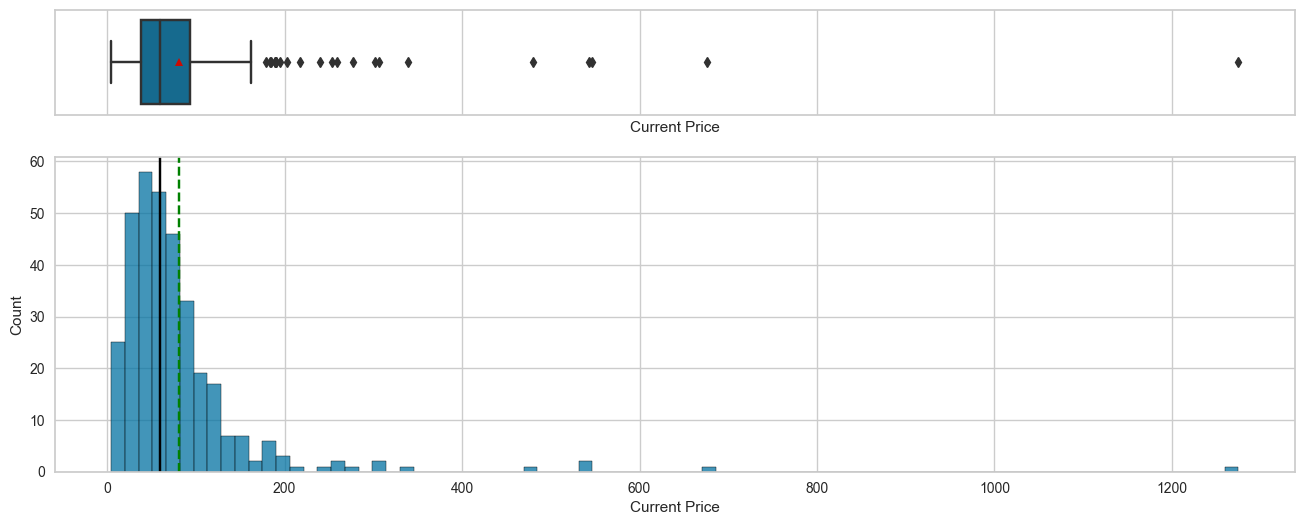

In [136]:
histogram_boxplot(td, 'Current Price')

Most of the stock prices are between $0-200 range.

* Price Change

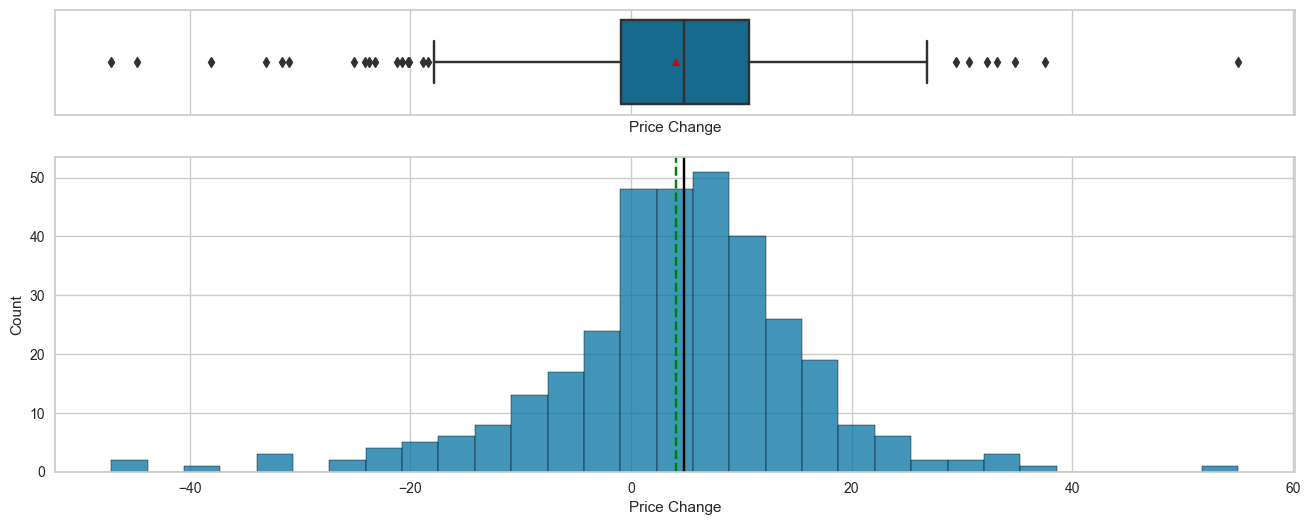

In [137]:
histogram_boxplot(td, 'Price Change')

The plots are leaned on the lower differences. But, the outliers on both sides indicate us that it has been evident of even falling to <-40% and high as >55% which might affect on our final predictions.

GICS Sector

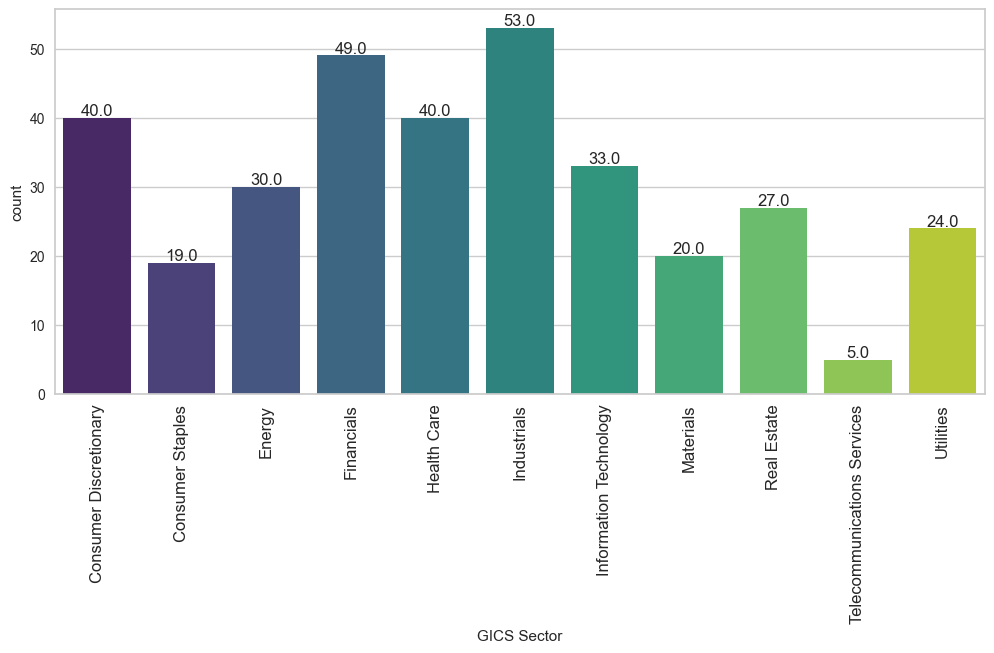

In [138]:
#A labeled barplot of stocks based on the sectors
labeled_barplot(td, 'GICS Sector')

We can see from the above bars that, 'industrials' holds the highest amount of stocks overall 53.0% and the Financials holding 49.0%. These two sectors are the highest among the different sectors.

In [139]:
#the top 5 leading sub-industries with the most amount of stocks. 
td['GICS Sector'].value_counts().head(5)

Industrials               53
Financials                49
Consumer Discretionary    40
Health Care               40
Information Technology    33
Name: GICS Sector, dtype: int64

The highest stocks belongs to the 'Industrials' sector and we can see that the industries are pretty diversified with a lot of sectors with small- average gaps overall.

GICS Sub Industry

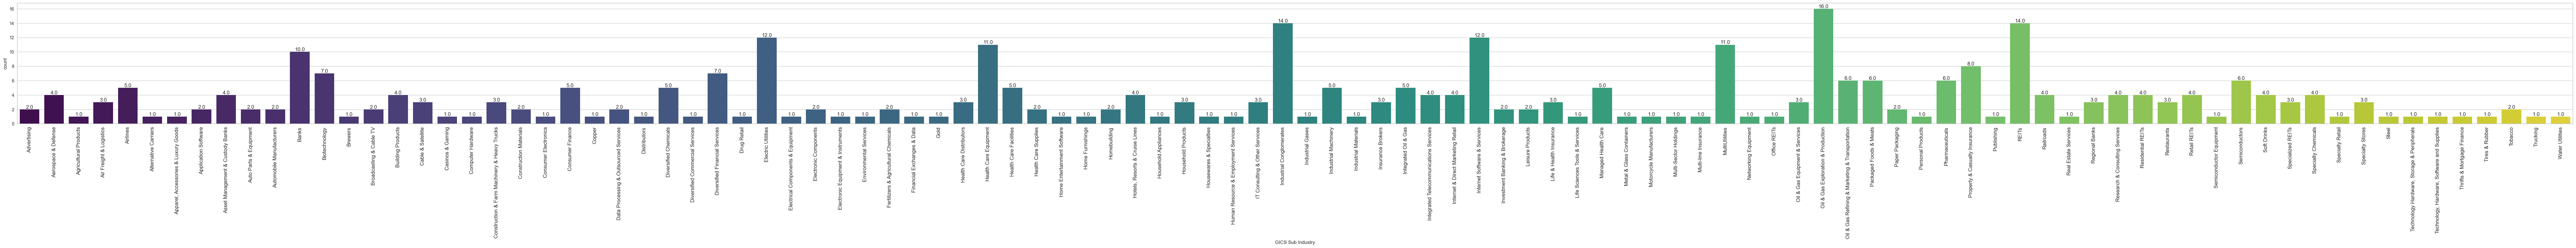

In [140]:
#A labeled barplot of stocks based on the sub-industries
labeled_barplot(td, 'GICS Sub Industry')

In [141]:
#the top 3 leading sub-industries with the most amount of stocks. 
td['GICS Sub Industry'].value_counts().head(3)

Oil & Gas Exploration & Production    16
REITs                                 14
Industrial Conglomerates              14
Name: GICS Sub Industry, dtype: int64

The most stocks are owned by the 'Oil and Gas Exploration and Production' subindustry but, 16 is the highest number of stocks among all the number of stocks owned by the sub-industries. Respectively REIT and Industrial Conglomerates came next with 14 socks as the second and third highest sub-industries of owning stocks.

* Volatility

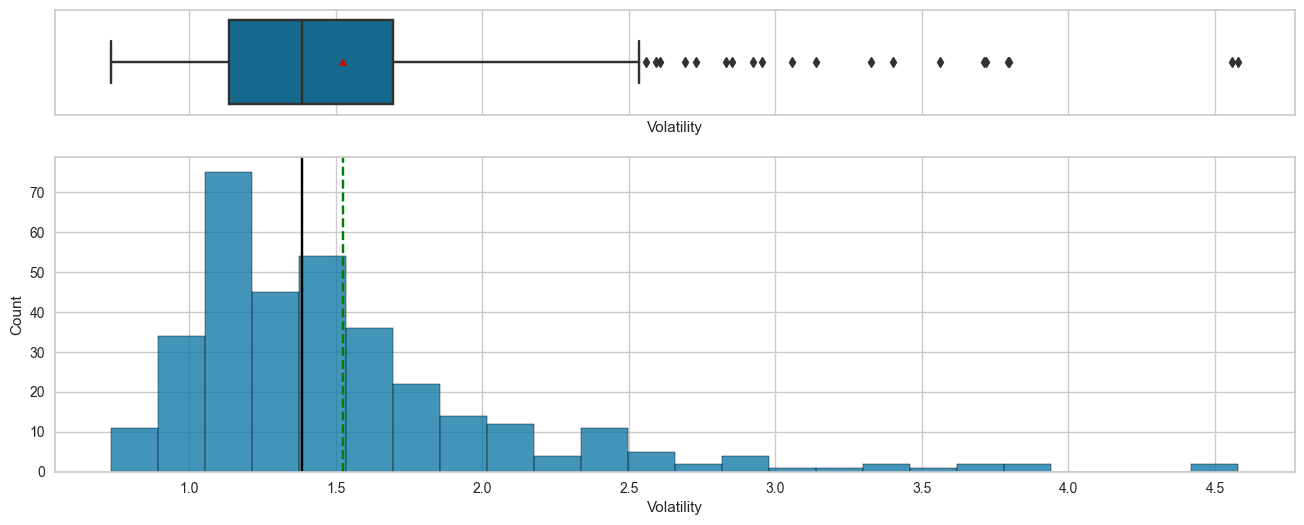

In [142]:
histogram_boxplot(td,'Volatility')      #will generate the boxplot of Volatility

* Net Cash Flow

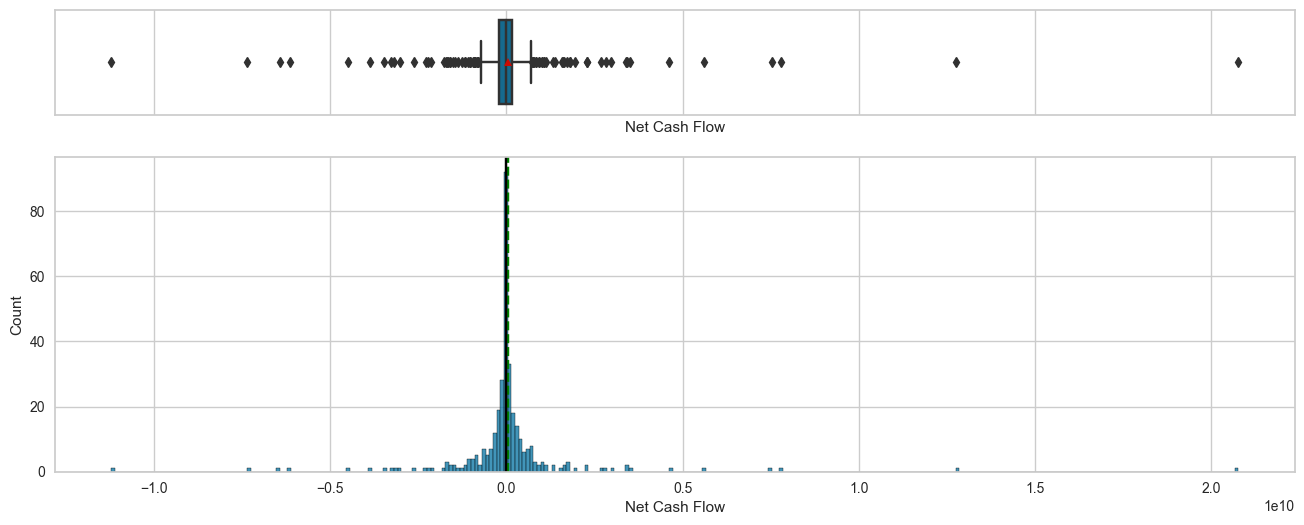

In [143]:
histogram_boxplot(td, 'Net Cash Flow')

* Earnings Per Share

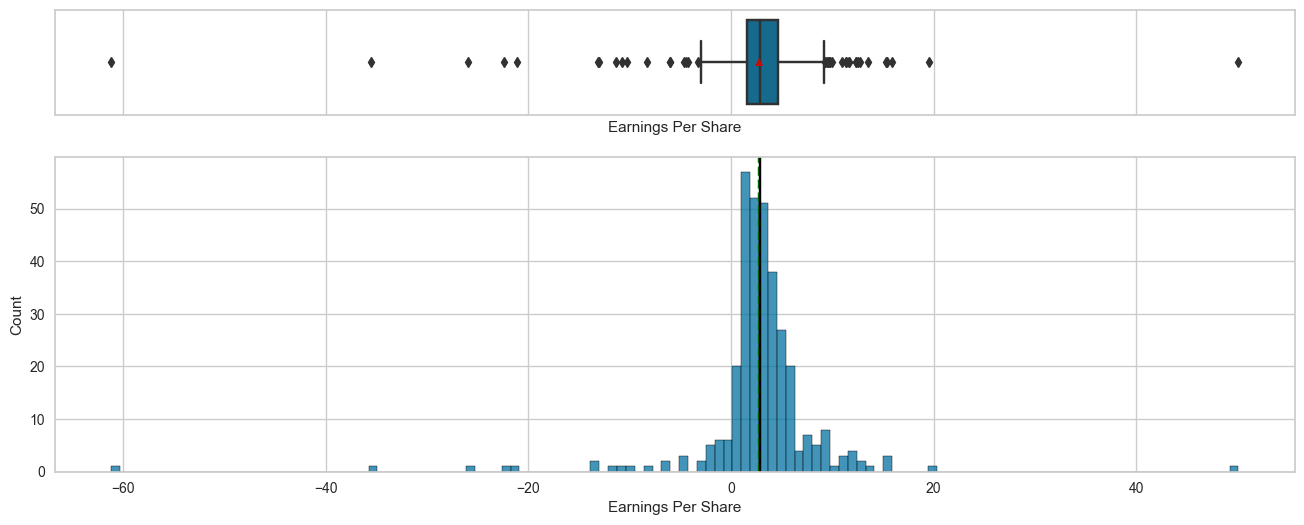

In [144]:
histogram_boxplot(td, 'Earnings Per Share')

* Estimated Shares Outstanding

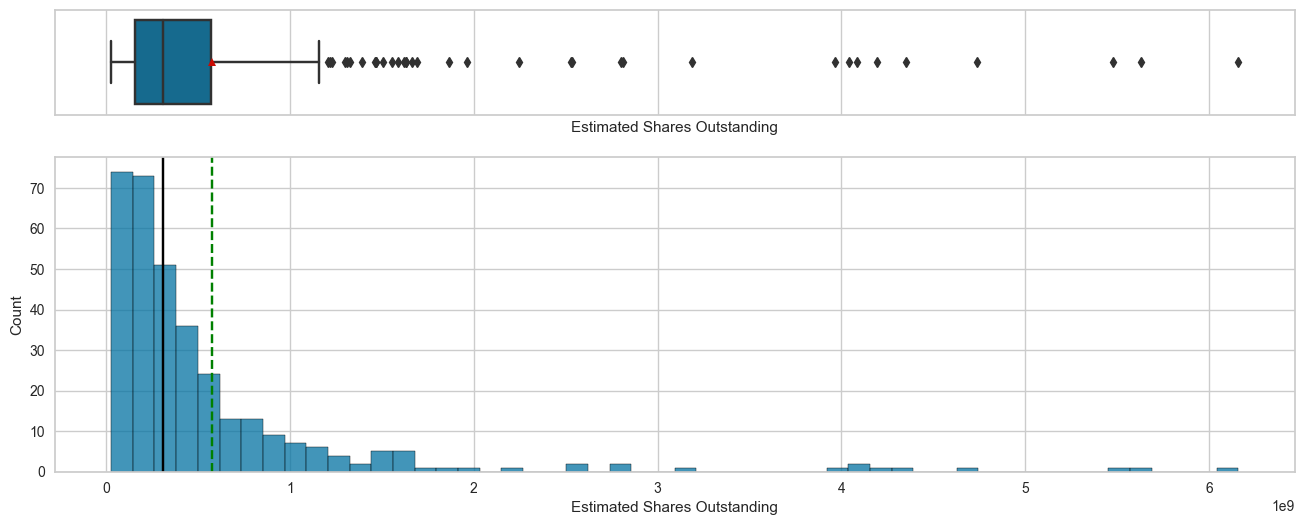

In [145]:
histogram_boxplot(td, 'Estimated Shares Outstanding')

* ROE

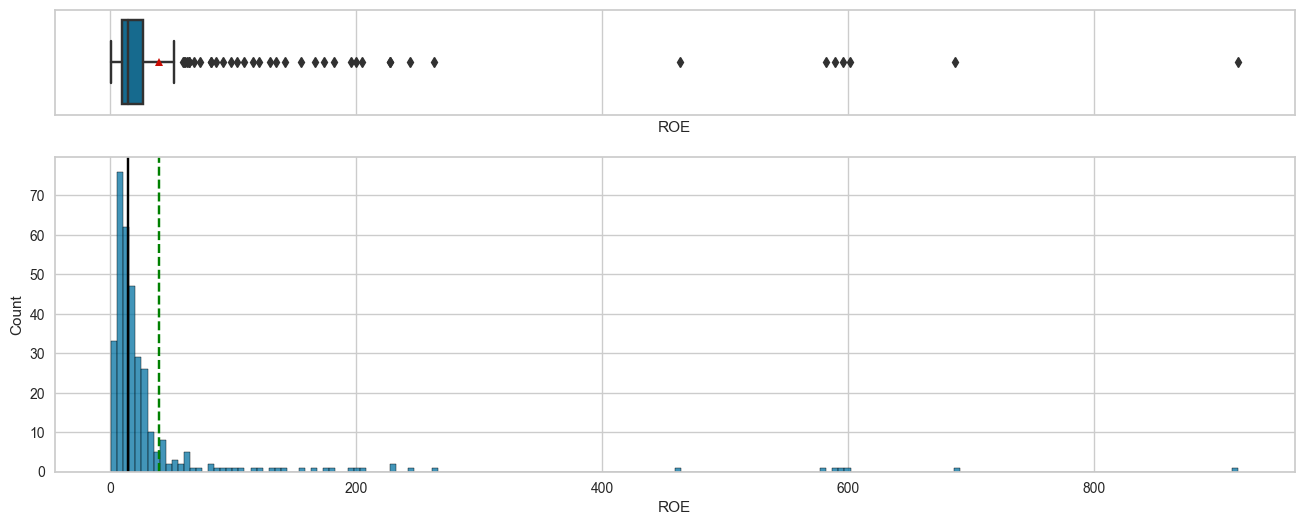

In [146]:
histogram_boxplot(td, 'ROE')

* P/E Ratio

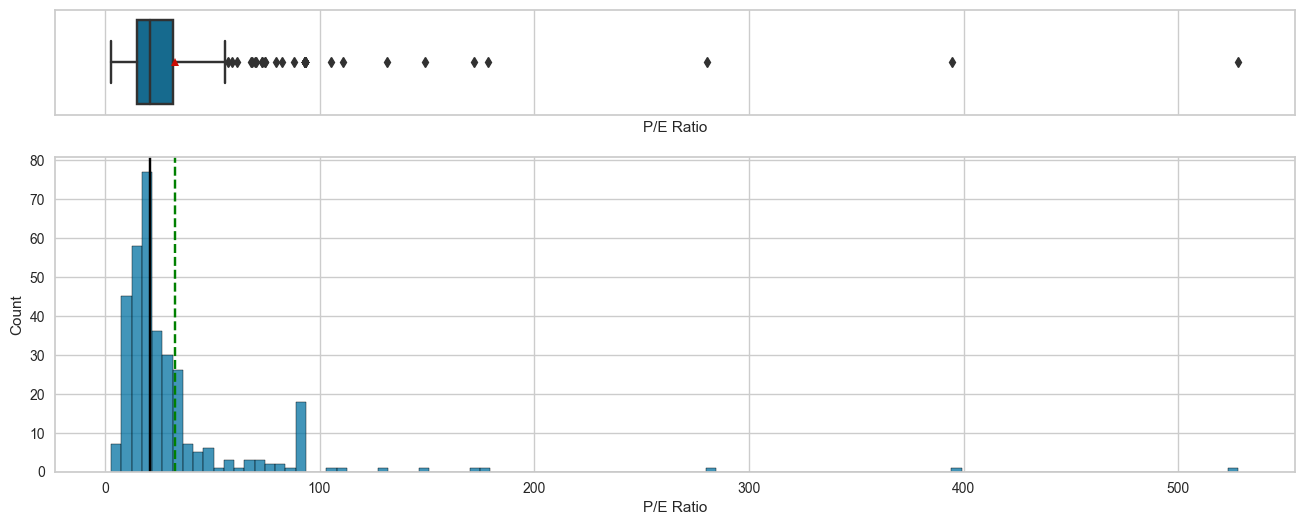

In [147]:
histogram_boxplot(td, 'P/E Ratio')

* P/B Ratio

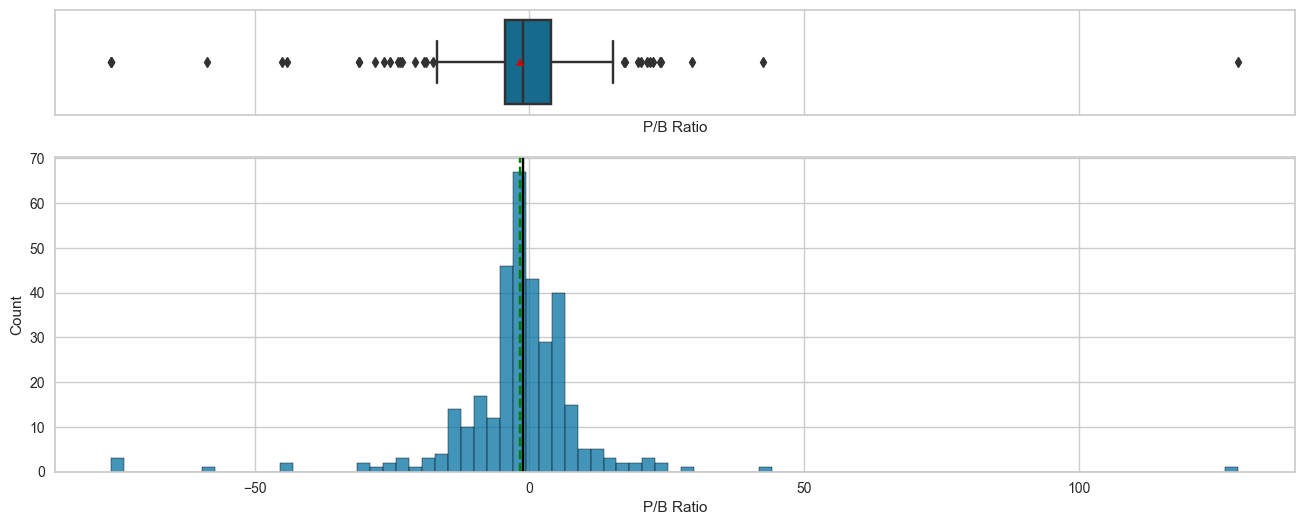

In [148]:
histogram_boxplot(td, 'P/B Ratio')

* Net Income

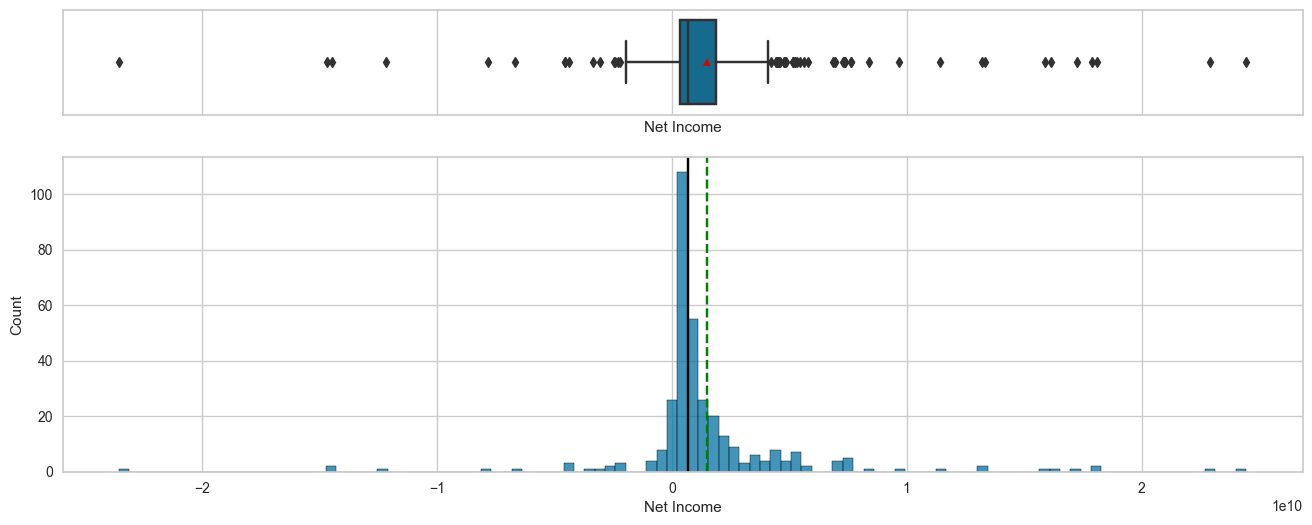

In [149]:
histogram_boxplot(td , 'Net Income')

* Volatility


Does not have a normal distribution and we can see that mean deviation is lower than 1.5 and right-skewed.

* Net Income


We can see that the tail has extended into the far right also some parts into the far left. Companies tend to be positive on profit and also some has a high income too. But, some companies is going to debts as for their negative net income



* P/B ratio


We can see some far left negative ratios for P/B ratio and also most of the P/B ratio is negative anyways. We can see some outliers too.

* Cash Ratio


Heavily right skewed. And, dosen't appear to be a normally distributed data. The imbalance is a thing for this variable to focus.

* Estimated Shares Outstanding

The boxplot shows that the shareholders almost holding shares outstandingly. A case of it can barely stand out. Also heaviliy right skewed.

* P/E Ratio


The P/E ratio seems to be heavily right skewed. And no negative ratio overall.

* Bivariate Analysis

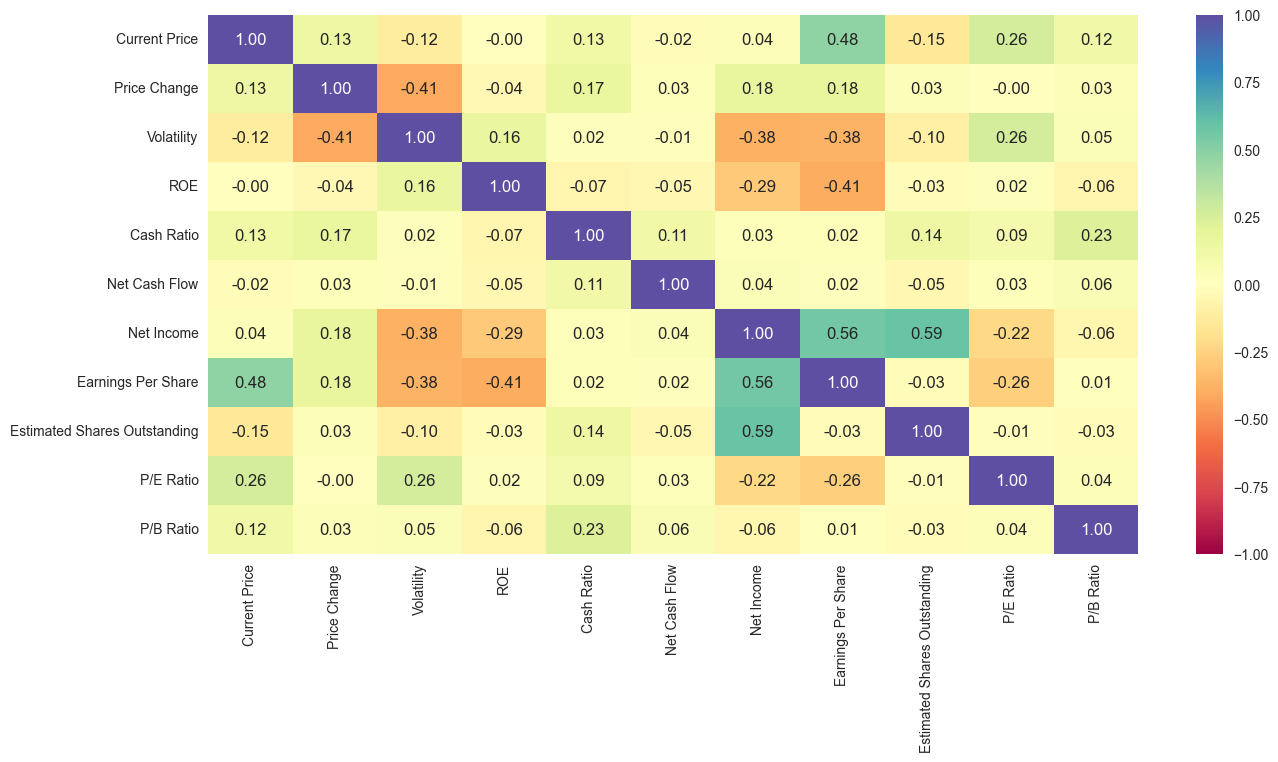

In [150]:
plt.figure(figsize=(15, 7))
sns.heatmap(
    td.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

We can see that volatility and current price has a negative correlation, even for net income vs volatility,  ROE and earnings per share and estimated share outstanding and current price they all share a negative co-relation. 

Net income is positievely co-related to earnings per share. 

Earnings per share is positively co-related with current price.

In [151]:
td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Security                      340 non-null    category
 1   GICS Sector                   340 non-null    category
 2   GICS Sub Industry             340 non-null    category
 3   Current Price                 340 non-null    float64 
 4   Price Change                  340 non-null    float64 
 5   Volatility                    340 non-null    float64 
 6   ROE                           340 non-null    int64   
 7   Cash Ratio                    340 non-null    int64   
 8   Net Cash Flow                 340 non-null    int64   
 9   Net Income                    340 non-null    int64   
 10  Earnings Per Share            340 non-null    float64 
 11  Estimated Shares Outstanding  340 non-null    float64 
 12  P/E Ratio                     340 non-null    floa

* GICS Sector vs ROE 

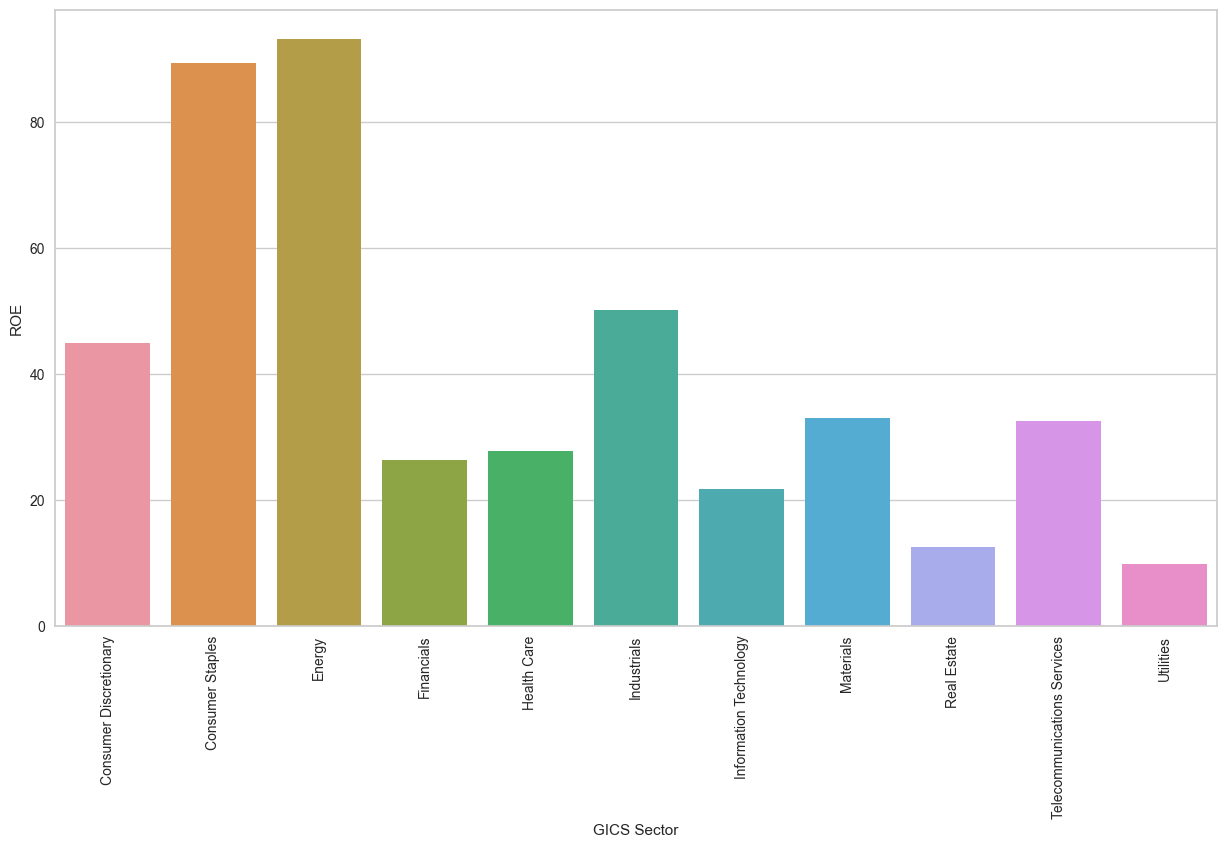

In [152]:
plt.figure(figsize=(15,8))
sns.barplot(data=td, x='GICS Sector', y='ROE', ci=False)
plt.xticks(rotation=90)
plt.show()

**Cash ratio provides a measure of a company's ability to cover its short-term obligations using only cash and cash equivalents. Let's see how the average cash ratio varies across economic sectors.**

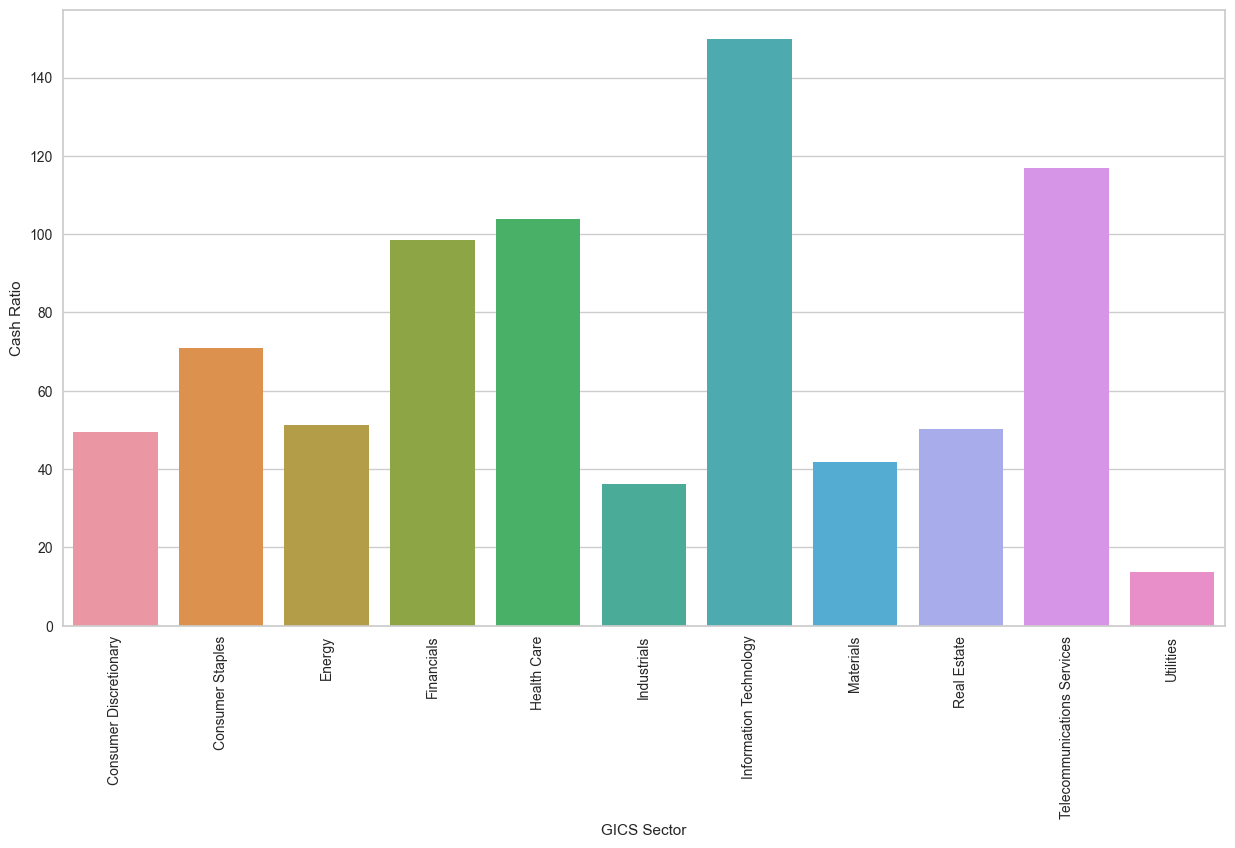

In [153]:
plt.figure(figsize=(15,8))
sns.barplot(data=td, x='GICS Sector', y='Cash Ratio', ci=False)  
plt.xticks(rotation=90)
plt.show()

* From the barplots we can see that the information techology gave more cash ratio's and after that telecommunication services. 

In [154]:
td.groupby('GICS Sector')['Cash Ratio'].mean().sort_values(ascending=False)

GICS Sector
Information Technology        149.82
Telecommunications Services   117.00
Health Care                   103.78
Financials                     98.59
Consumer Staples               70.95
Energy                         51.13
Real Estate                    50.11
Consumer Discretionary         49.58
Materials                      41.70
Industrials                    36.19
Utilities                      13.62
Name: Cash Ratio, dtype: float64

From sorting the variables by the mean values we can see that the top sectors are 'GICS Sector', 'Information Technology' , Telecommunication Services', 'Health Care' respectively.

**P/E ratios can help determine the relative value of a company's shares as they signify the amount of money an investor is willing to invest in a single share of a company per dollar of its earnings. Let's see how the P/E ratio varies, on average, across economic sectors.**

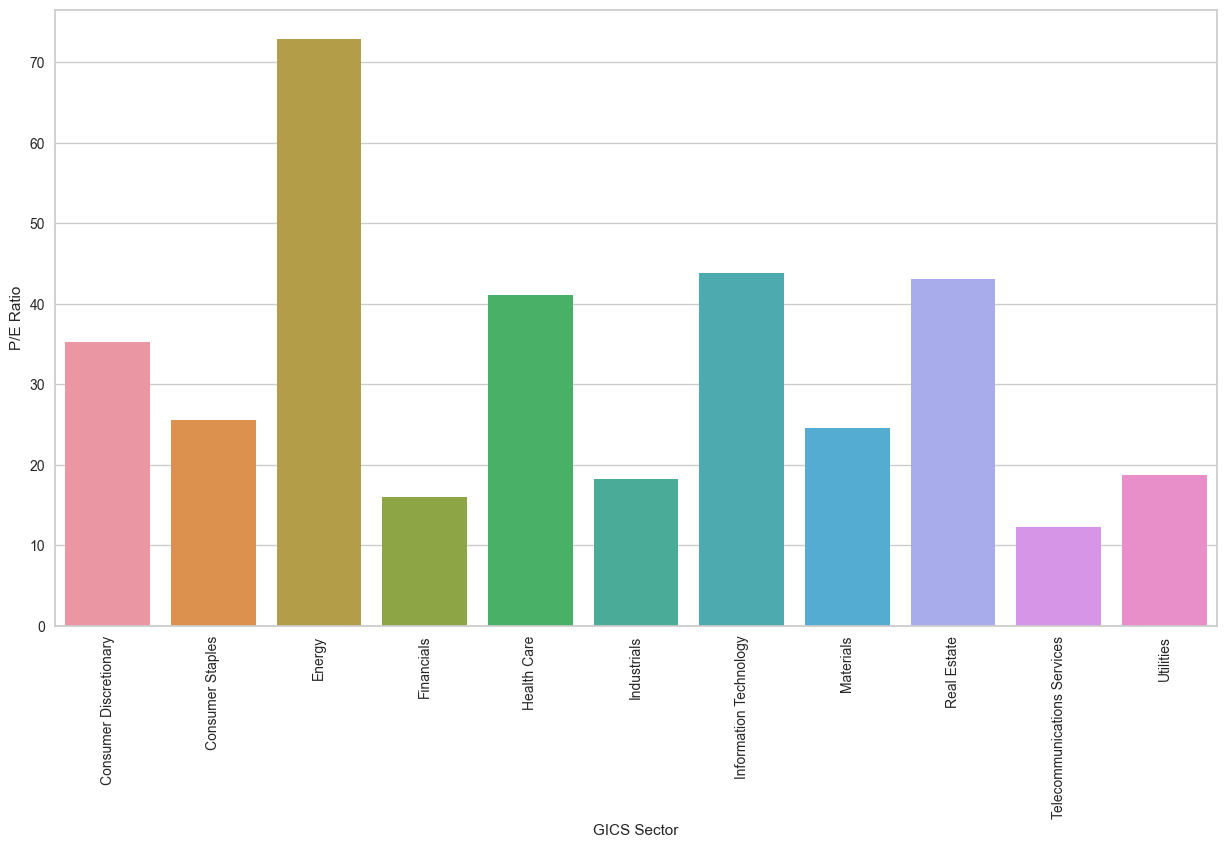

In [155]:
plt.figure(figsize=(15,8))
sns.barplot(data=td, x='GICS Sector', y='P/E Ratio', ci=False) 
plt.xticks(rotation=90)
plt.show()

In [156]:
td.groupby('GICS Sector')['P/E Ratio'].mean().sort_values(ascending=False)

GICS Sector
Energy                        72.90
Information Technology        43.78
Real Estate                   43.07
Health Care                   41.14
Consumer Discretionary        35.21
Consumer Staples              25.52
Materials                     24.59
Utilities                     18.72
Industrials                   18.26
Financials                    16.02
Telecommunications Services   12.22
Name: P/E Ratio, dtype: float64

* We can see the visual and the summary that Energy sector has the highest P/E ratio, followed by IT tech and real estate.

## Data Preprocessing

- Duplicate value check
- Missing value treatment
- Outlier check
- Feature engineering (if needed)
- Any other preprocessing steps (if needed)

* Duplicated Values 

In [157]:
td.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
335    False
336    False
337    False
338    False
339    False
Length: 340, dtype: bool

Even after our updated dataset, we can see that we do not have any duplicated values.

* Missing Values 

In [158]:
td.isnull().sum()

Security                        0
GICS Sector                     0
GICS Sub Industry               0
Current Price                   0
Price Change                    0
Volatility                      0
ROE                             0
Cash Ratio                      0
Net Cash Flow                   0
Net Income                      0
Earnings Per Share              0
Estimated Shares Outstanding    0
P/E Ratio                       0
P/B Ratio                       0
dtype: int64

* We can see we have no presence of the null values

* Outlier Checks

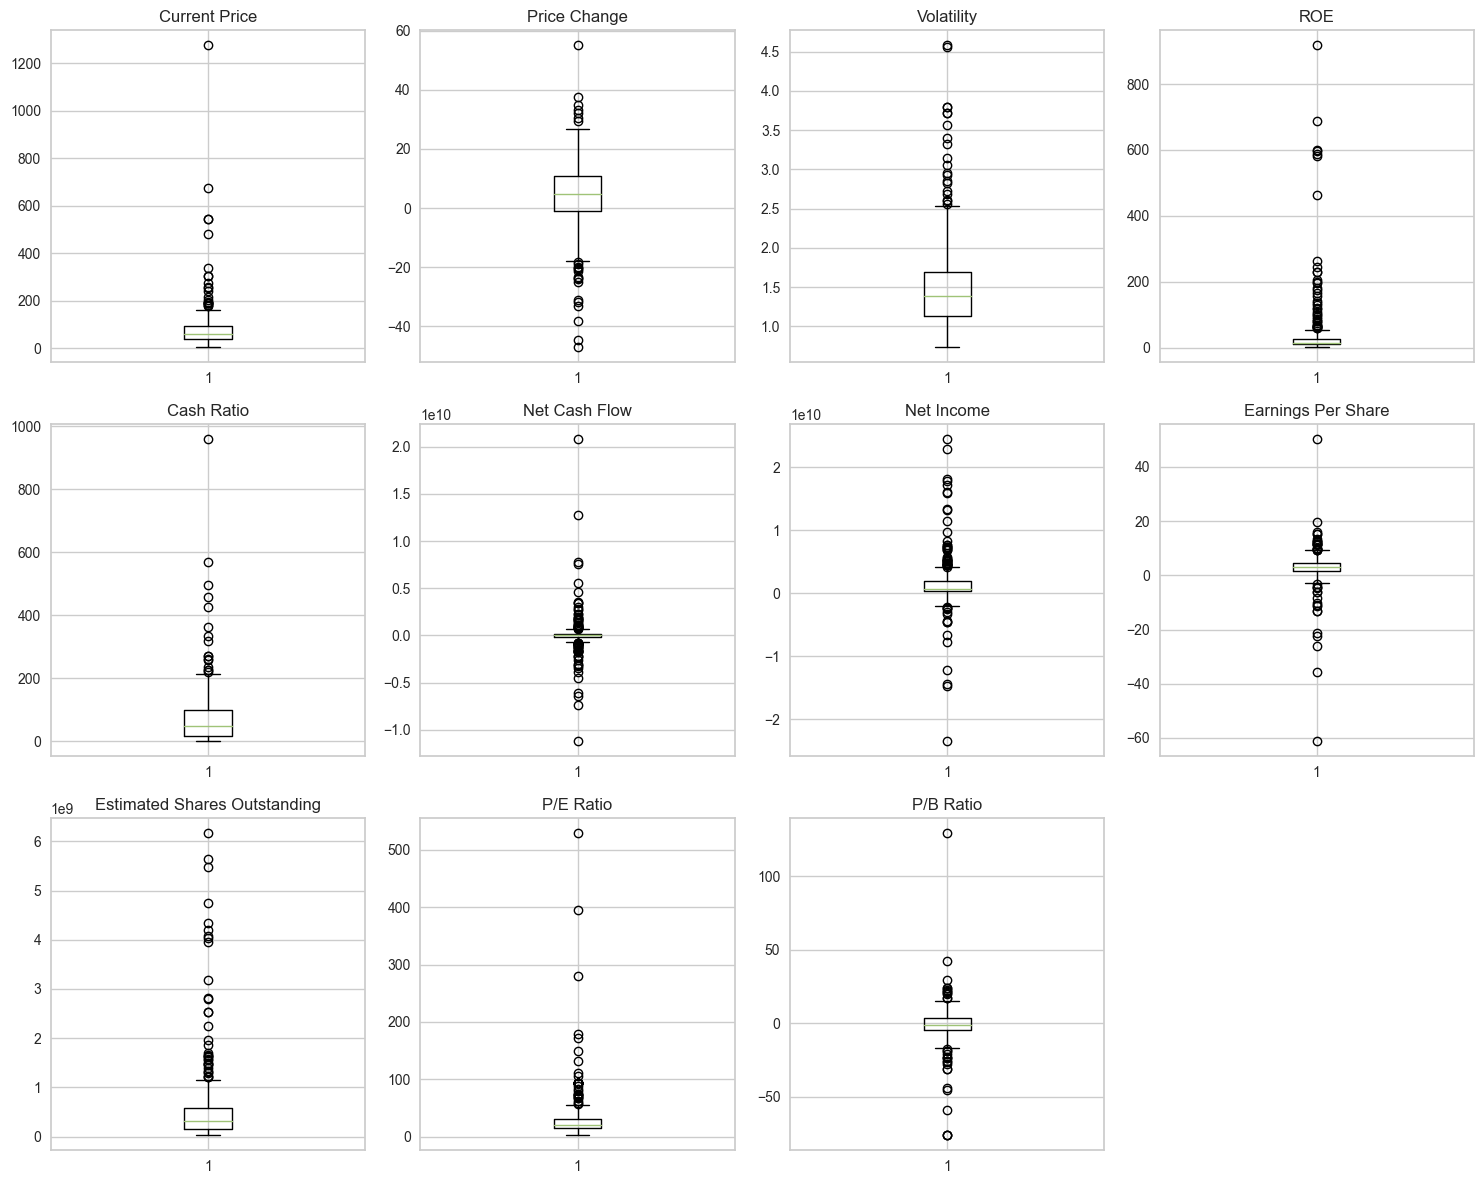

In [159]:
plt.figure(figsize=(15, 12))

numeric_columns = td.select_dtypes(include=np.number).columns.tolist()

for i, variable in enumerate(numeric_columns):
    plt.subplot(3, 4, i + 1)
    plt.boxplot(td[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

We can see we have outliers in almost for every columns. This might play a role at our final predictions.

In [160]:
#create list of columns with numerical variables
num_col = td.select_dtypes(include=np.number).columns.tolist()

## K-means Clustering

In [161]:
#scale the data set before clustering
scaler = StandardScaler()
subset = td[num_col].copy()
subset_scaled = scaler.fit_transform(subset)

In [162]:
#create a dataframe from the scaled data
subset_scaled_td = pd.DataFrame(subset_scaled, columns=subset.columns)


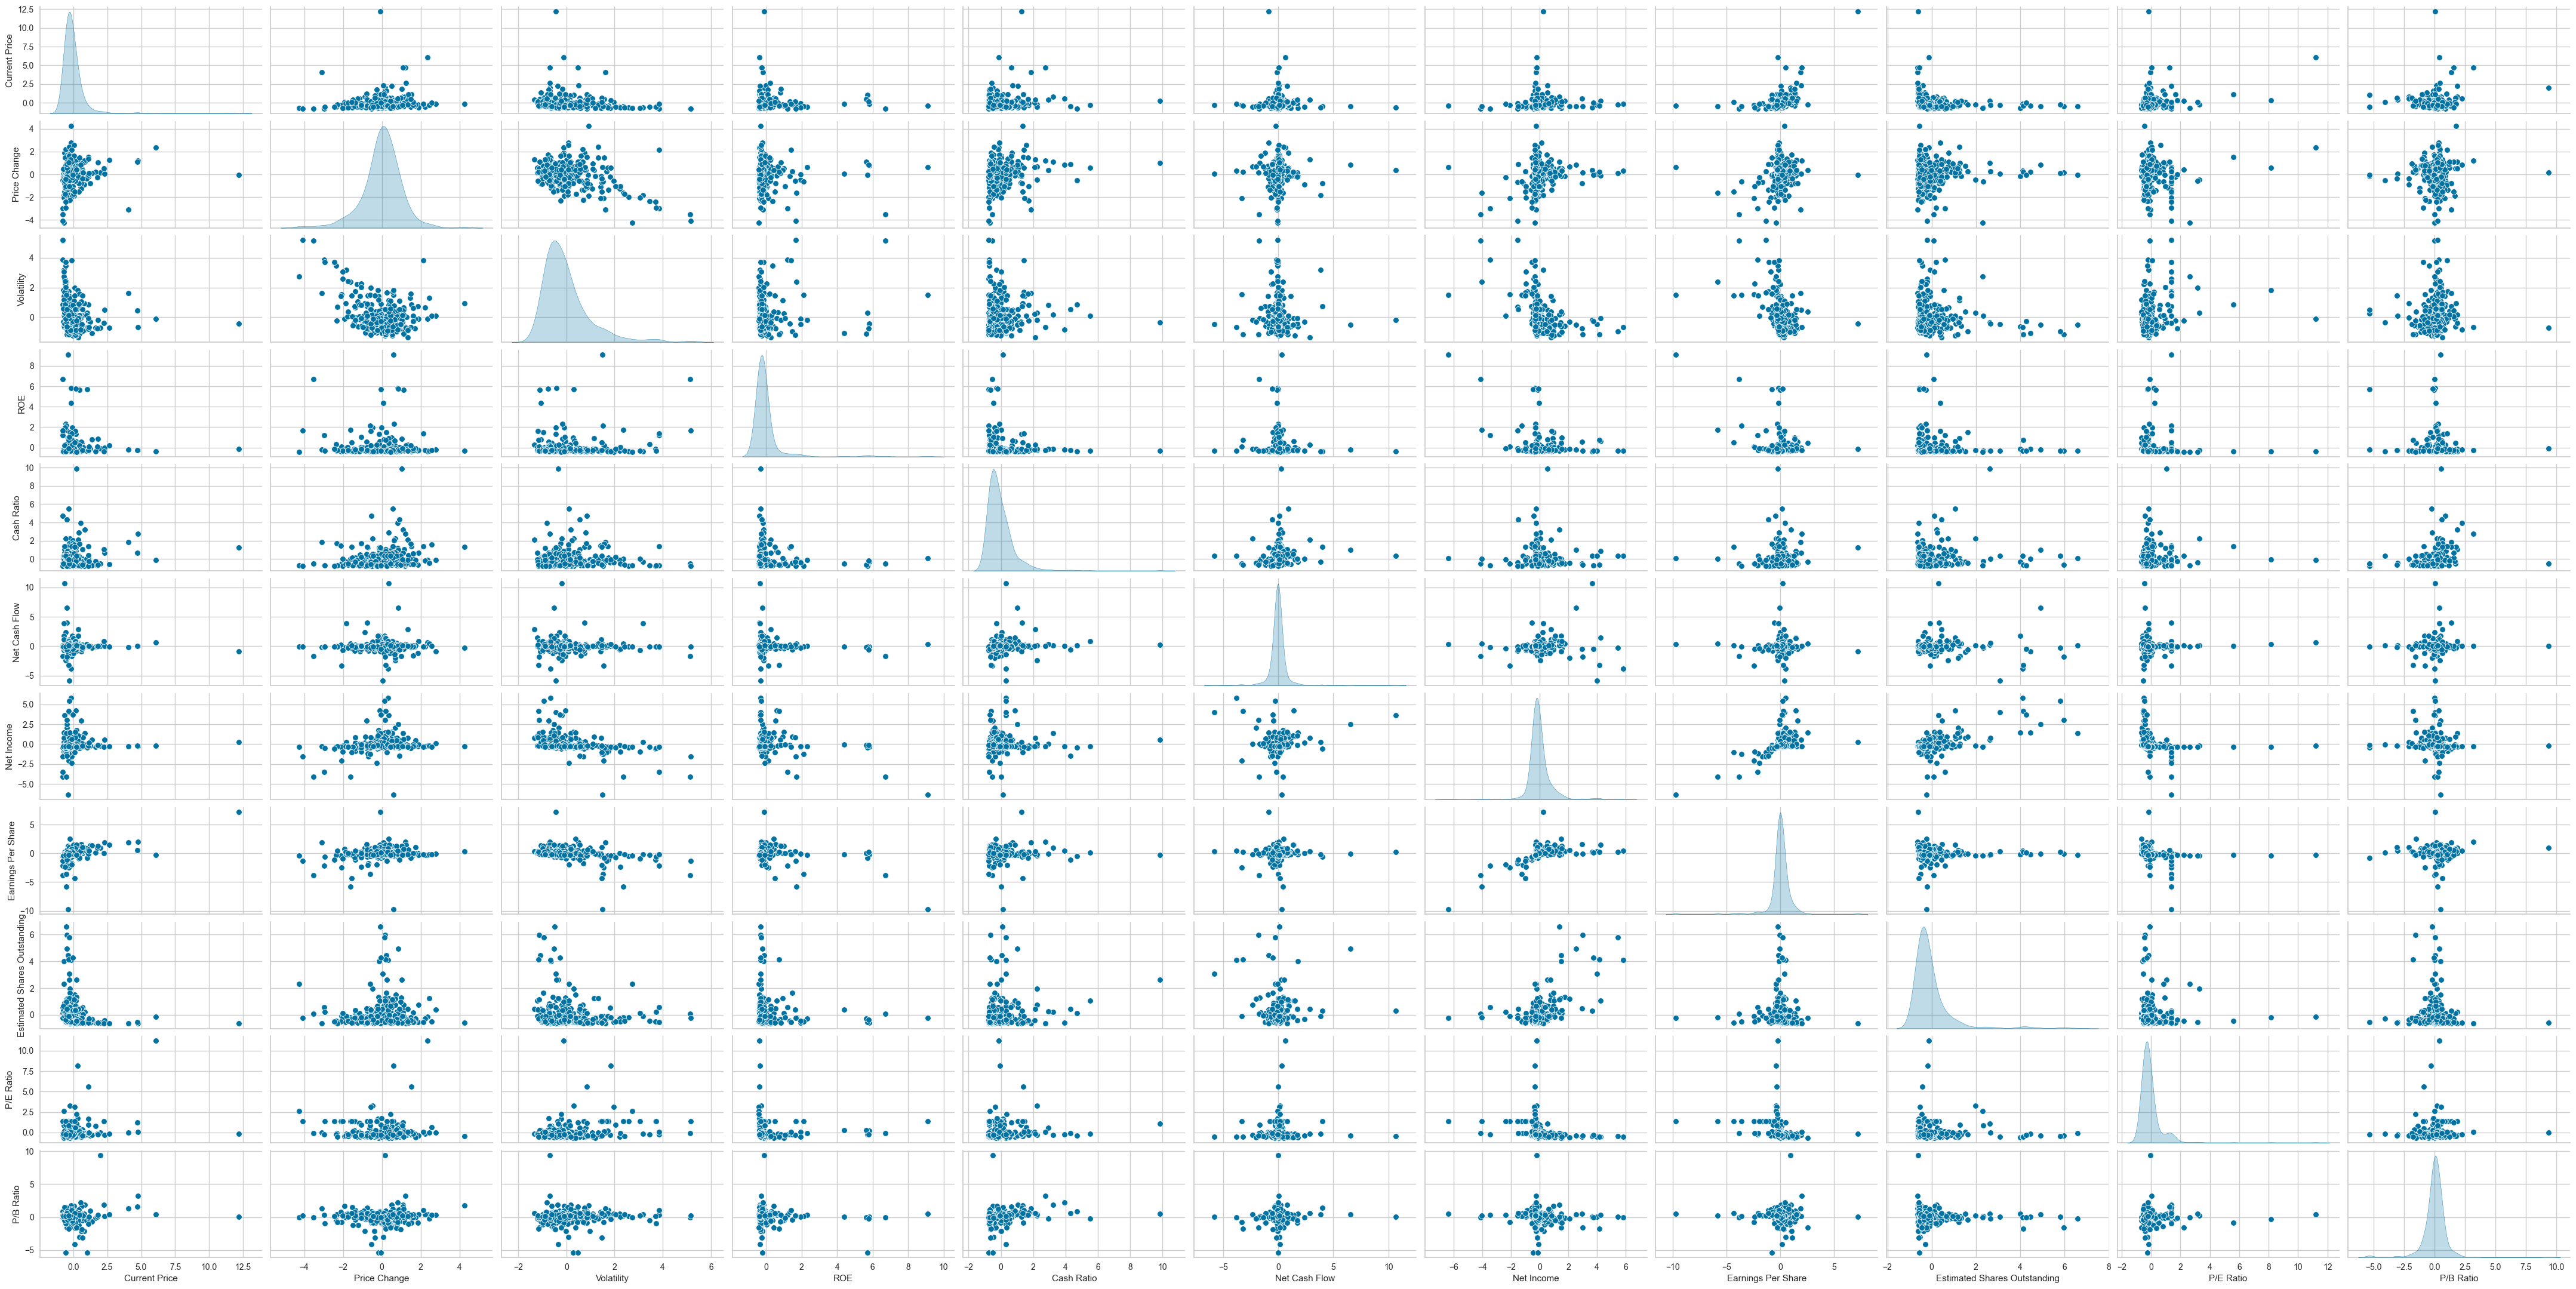

In [163]:
#create pairplot for scaled dataframe
sns.pairplot(subset_scaled_td, height=2,aspect=2 , diag_kind='kde')
plt.show()

* Checking Elbow Plot

In [164]:
k_means_df = subset_scaled_td.copy()

Number of Clusters: 1 	Average Distortion: 2.5425069919221697
Number of Clusters: 2 	Average Distortion: 2.382318498894466
Number of Clusters: 3 	Average Distortion: 2.267596864267437
Number of Clusters: 4 	Average Distortion: 2.178151429073042
Number of Clusters: 5 	Average Distortion: 2.1277144764991163
Number of Clusters: 6 	Average Distortion: 2.088786281986941
Number of Clusters: 7 	Average Distortion: 2.0383149185355345
Number of Clusters: 8 	Average Distortion: 1.9907445164698618
Number of Clusters: 9 	Average Distortion: 1.8957432837183497
Number of Clusters: 10 	Average Distortion: 1.8665012362102018


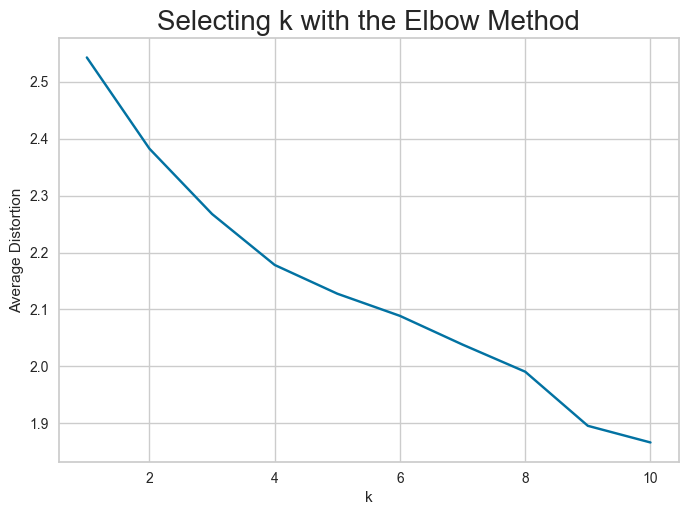

In [165]:
clusters = range(1, 11)
# Creating an empty list to store average distortions for each cluster number
meanDistortions = []
# Iterating through the cluster numbers
for k in clusters:
    # Creating a KMeans clustering model with the current number of clusters (k)
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_td)
    # Predict cluster assignments for the entire dataset 'k_means_df'
    prediction = model.predict(k_means_df)
     # Calculates the distortion (average distance from each data point to its assigned cluster center)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_td, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_td.shape[0]
    )
    
    # Append the calculated average distortion to the 'meanDistortions' list
    meanDistortions.append(distortion)
    # Prints the current number of clusters and its corresponding average distortion
    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

# Creates a line plot to visualize the relationship between the number of clusters and average distortions
plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)

# The plot will be displayed
plt.show()


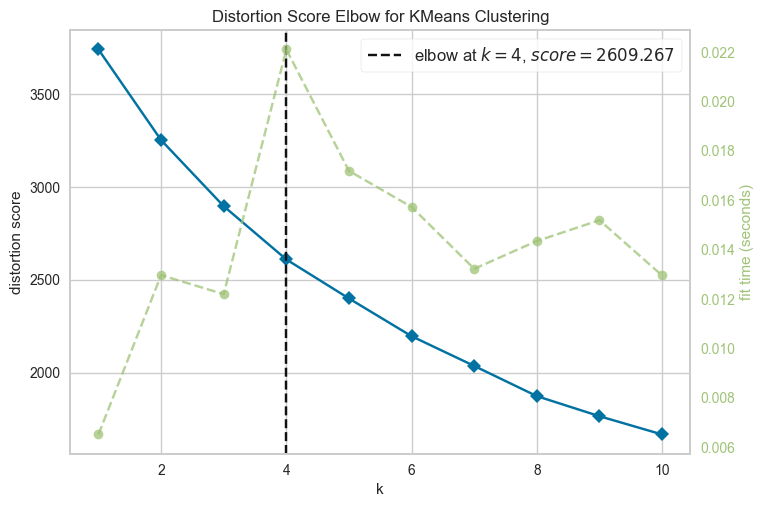

In [166]:
#fit KMeans model and use visualizaer to indicate optimal K value
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(1, 11), timings=True)
visualizer.fit(k_means_df)  # fit the data to the visualizer
visualizer.show()  # finalize and render figure
plt.show()

For n_clusters = 2, the silhouette score is 0.43969639509980457)
For n_clusters = 3, the silhouette score is 0.4644405674779404)
For n_clusters = 4, the silhouette score is 0.45434371948348606)
For n_clusters = 5, the silhouette score is 0.43169988466492354)
For n_clusters = 6, the silhouette score is 0.36698524210914063)
For n_clusters = 7, the silhouette score is 0.10587349598463779)
For n_clusters = 8, the silhouette score is 0.40021596082234684)
For n_clusters = 9, the silhouette score is 0.4051539505522535)
For n_clusters = 10, the silhouette score is 0.1147132918355368)
For n_clusters = 11, the silhouette score is 0.16268826704862682)
For n_clusters = 12, the silhouette score is 0.12883008320005324)
For n_clusters = 13, the silhouette score is 0.1744804713048242)
For n_clusters = 14, the silhouette score is 0.17597674098501367)


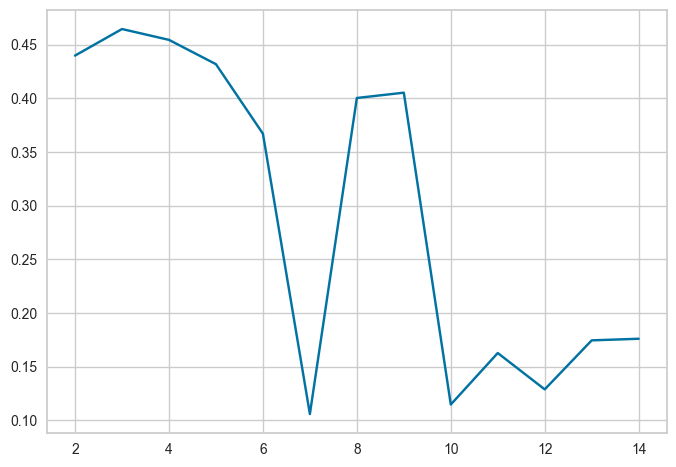

In [167]:
# Creating an empty list to store silhouette scores
sil_score = []

# Define a range of cluster numbers to try (from 2 to 14 clusters)
cluster_list = range(2, 15)

# Will iterate through the cluster numbers
for n_clusters in cluster_list:
    # Creating a KMeans clustering model with the current number of clusters
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    
    # Fit the KMeans model to the data in 'k_means_df' and obtain cluster assignments
    preds = clusterer.fit_predict(k_means_df)
    
    # Calculating the silhouette score for the current clustering
    score = silhouette_score(k_means_df, preds)
    
    # Will append the silhouette score to the 'sil_score' list
    sil_score.append(score)
    
    # Will print the silhouette score for the current number of clusters
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

# Creates a line plot to visualize the relationship between the number of clusters and silhouette scores
plt.plot(cluster_list, sil_score)

# Plot will be displayed
plt.show()


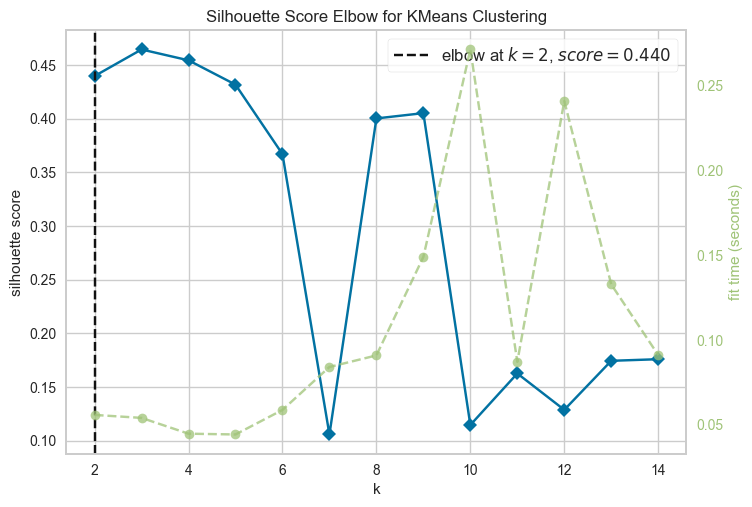

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [168]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2, 15), metric="silhouette", timings=True)
visualizer.fit(k_means_df)  # fit the data to the visualizer
visualizer.show()  # finalize and render figure

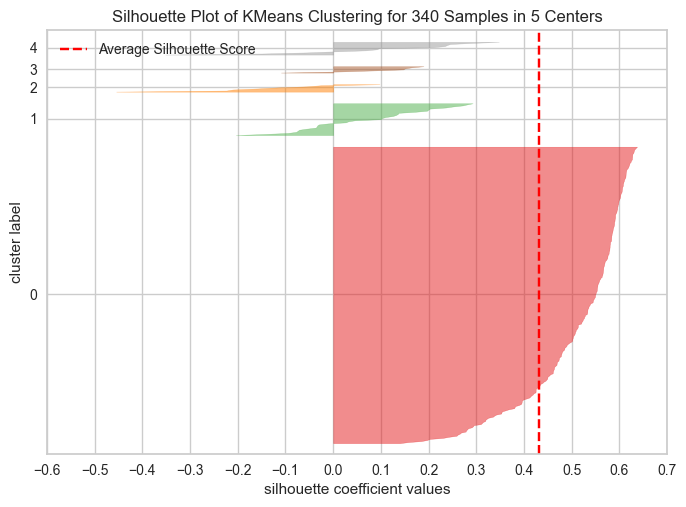

In [169]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))  ## Complete the code to visualize the silhouette scores for certain number of clusters
visualizer.fit(k_means_df)
visualizer.show();

* The best performance appears to be 5 between the Elbow and Silhouette plots.

In [170]:
#create kmeans cluster model
kmeans = KMeans(n_clusters=5, random_state=42)

#fit model to scaled dataset
kmeans.fit(k_means_df)

KMeans(n_clusters=5, random_state=42)

In [171]:
# creating a copy of the original data
td1 = td.copy()

# adding kmeans cluster labels to the original and scaled dataframes
k_means_df["KM_segments"] = kmeans.labels_
td1["KM_segments"] = kmeans.labels_

* Cluster Profiling

In [172]:
km_clst_prof = td1.groupby("KM_segments").mean()
#add counts for number of stocks in every cluster
km_clst_prof["Count"] = (
    td1.groupby("KM_segments")["Current Price"].count().values
)


In [173]:
km_clst_prof.style.highlight_max(color="lightgreen", axis=0)

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,Count
KM_segments,,,,,,,,,,,,
0,73.458985,4.908289,1.381480,34.996324,50.169118,-6010529.411765,1500021988.970588,3.702518,430274527.337537,23.661694,-3.534065,272
1,632.714991,7.374164,1.541343,19.333333,158.333333,-24046333.333333,907393166.666667,16.270000,125797901.323333,123.049240,35.355736,6
2,88.820556,14.960905,1.783471,24.791667,292.750000,1531729250.000000,1518241000.000000,2.060417,755930067.074167,54.351538,7.448500,24
3,38.099260,-15.370329,2.910500,107.074074,50.037037,-159428481.481481,-3887457740.740741,-9.473704,480398572.845926,90.619220,1.342067,27
4,50.517273,5.747586,1.130399,31.090909,75.909091,-1072272727.272727,14833090909.090910,4.154545,4298826628.727273,14.803577,-4.552119,11


In [174]:
# will generate the names of the companies in each cluster
for cl in td1["KM_segments"].unique():
    print("In cluster {}, the following companies are present:".format(cl))
    print(td1[td1["KM_segments"] == cl]["Security"].unique().to_list())
    print()

In cluster 0, the following companies are present:
['American Airlines Group', 'AbbVie', 'Abbott Laboratories', 'Archer-Daniels-Midland Co', 'Ameren Corp', 'American Electric Power', 'AFLAC Inc', 'American International Group, Inc.', 'Apartment Investment & Mgmt', 'Assurant Inc', 'Arthur J. Gallagher & Co.', 'Akamai Technologies Inc', 'Albemarle Corp', 'Alaska Air Group Inc', 'Allstate Corp', 'Allegion', 'AMETEK Inc', 'Affiliated Managers Group Inc', 'Ameriprise Financial', 'American Tower Corp A', 'AutoNation Inc', 'Anthem Inc.', 'Aon plc', 'Amphenol Corp', 'Arconic Inc', 'Activision Blizzard', 'AvalonBay Communities, Inc.', 'American Water Works Company Inc', 'American Express Co', 'Boeing Company', 'Baxter International Inc.', 'BB&T Corporation', 'Bard (C.R.) Inc.', 'BIOGEN IDEC Inc.', 'The Bank of New York Mellon Corp.', 'Ball Corp', 'Bristol-Myers Squibb', 'Boston Scientific', 'BorgWarner', 'Boston Properties', 'Caterpillar Inc.', 'Chubb Limited', 'CBRE Group', 'Crown Castle Inter

In [175]:
#Generates the number of stocks associated with all the clusters
for k in range(0,td1['KM_segments'].nunique()):
    print('Number of stocks within each GICS Sector for Cluster '+str(k)+' are:')
    print(td1[td1['KM_segments']==k]['GICS Sector'].value_counts())
    print("   ")

Number of stocks within each GICS Sector for Cluster 0 are:
Industrials                    52
Financials                     45
Consumer Discretionary         33
Health Care                    30
Real Estate                    26
Utilities                      24
Information Technology         19
Materials                      18
Consumer Staples               17
Energy                          6
Telecommunications Services     2
Name: GICS Sector, dtype: int64
   
Number of stocks within each GICS Sector for Cluster 1 are:
Consumer Discretionary         3
Health Care                    2
Information Technology         1
Consumer Staples               0
Energy                         0
Financials                     0
Industrials                    0
Materials                      0
Real Estate                    0
Telecommunications Services    0
Utilities                      0
Name: GICS Sector, dtype: int64
   
Number of stocks within each GICS Sector for Cluster 2 are:
Information

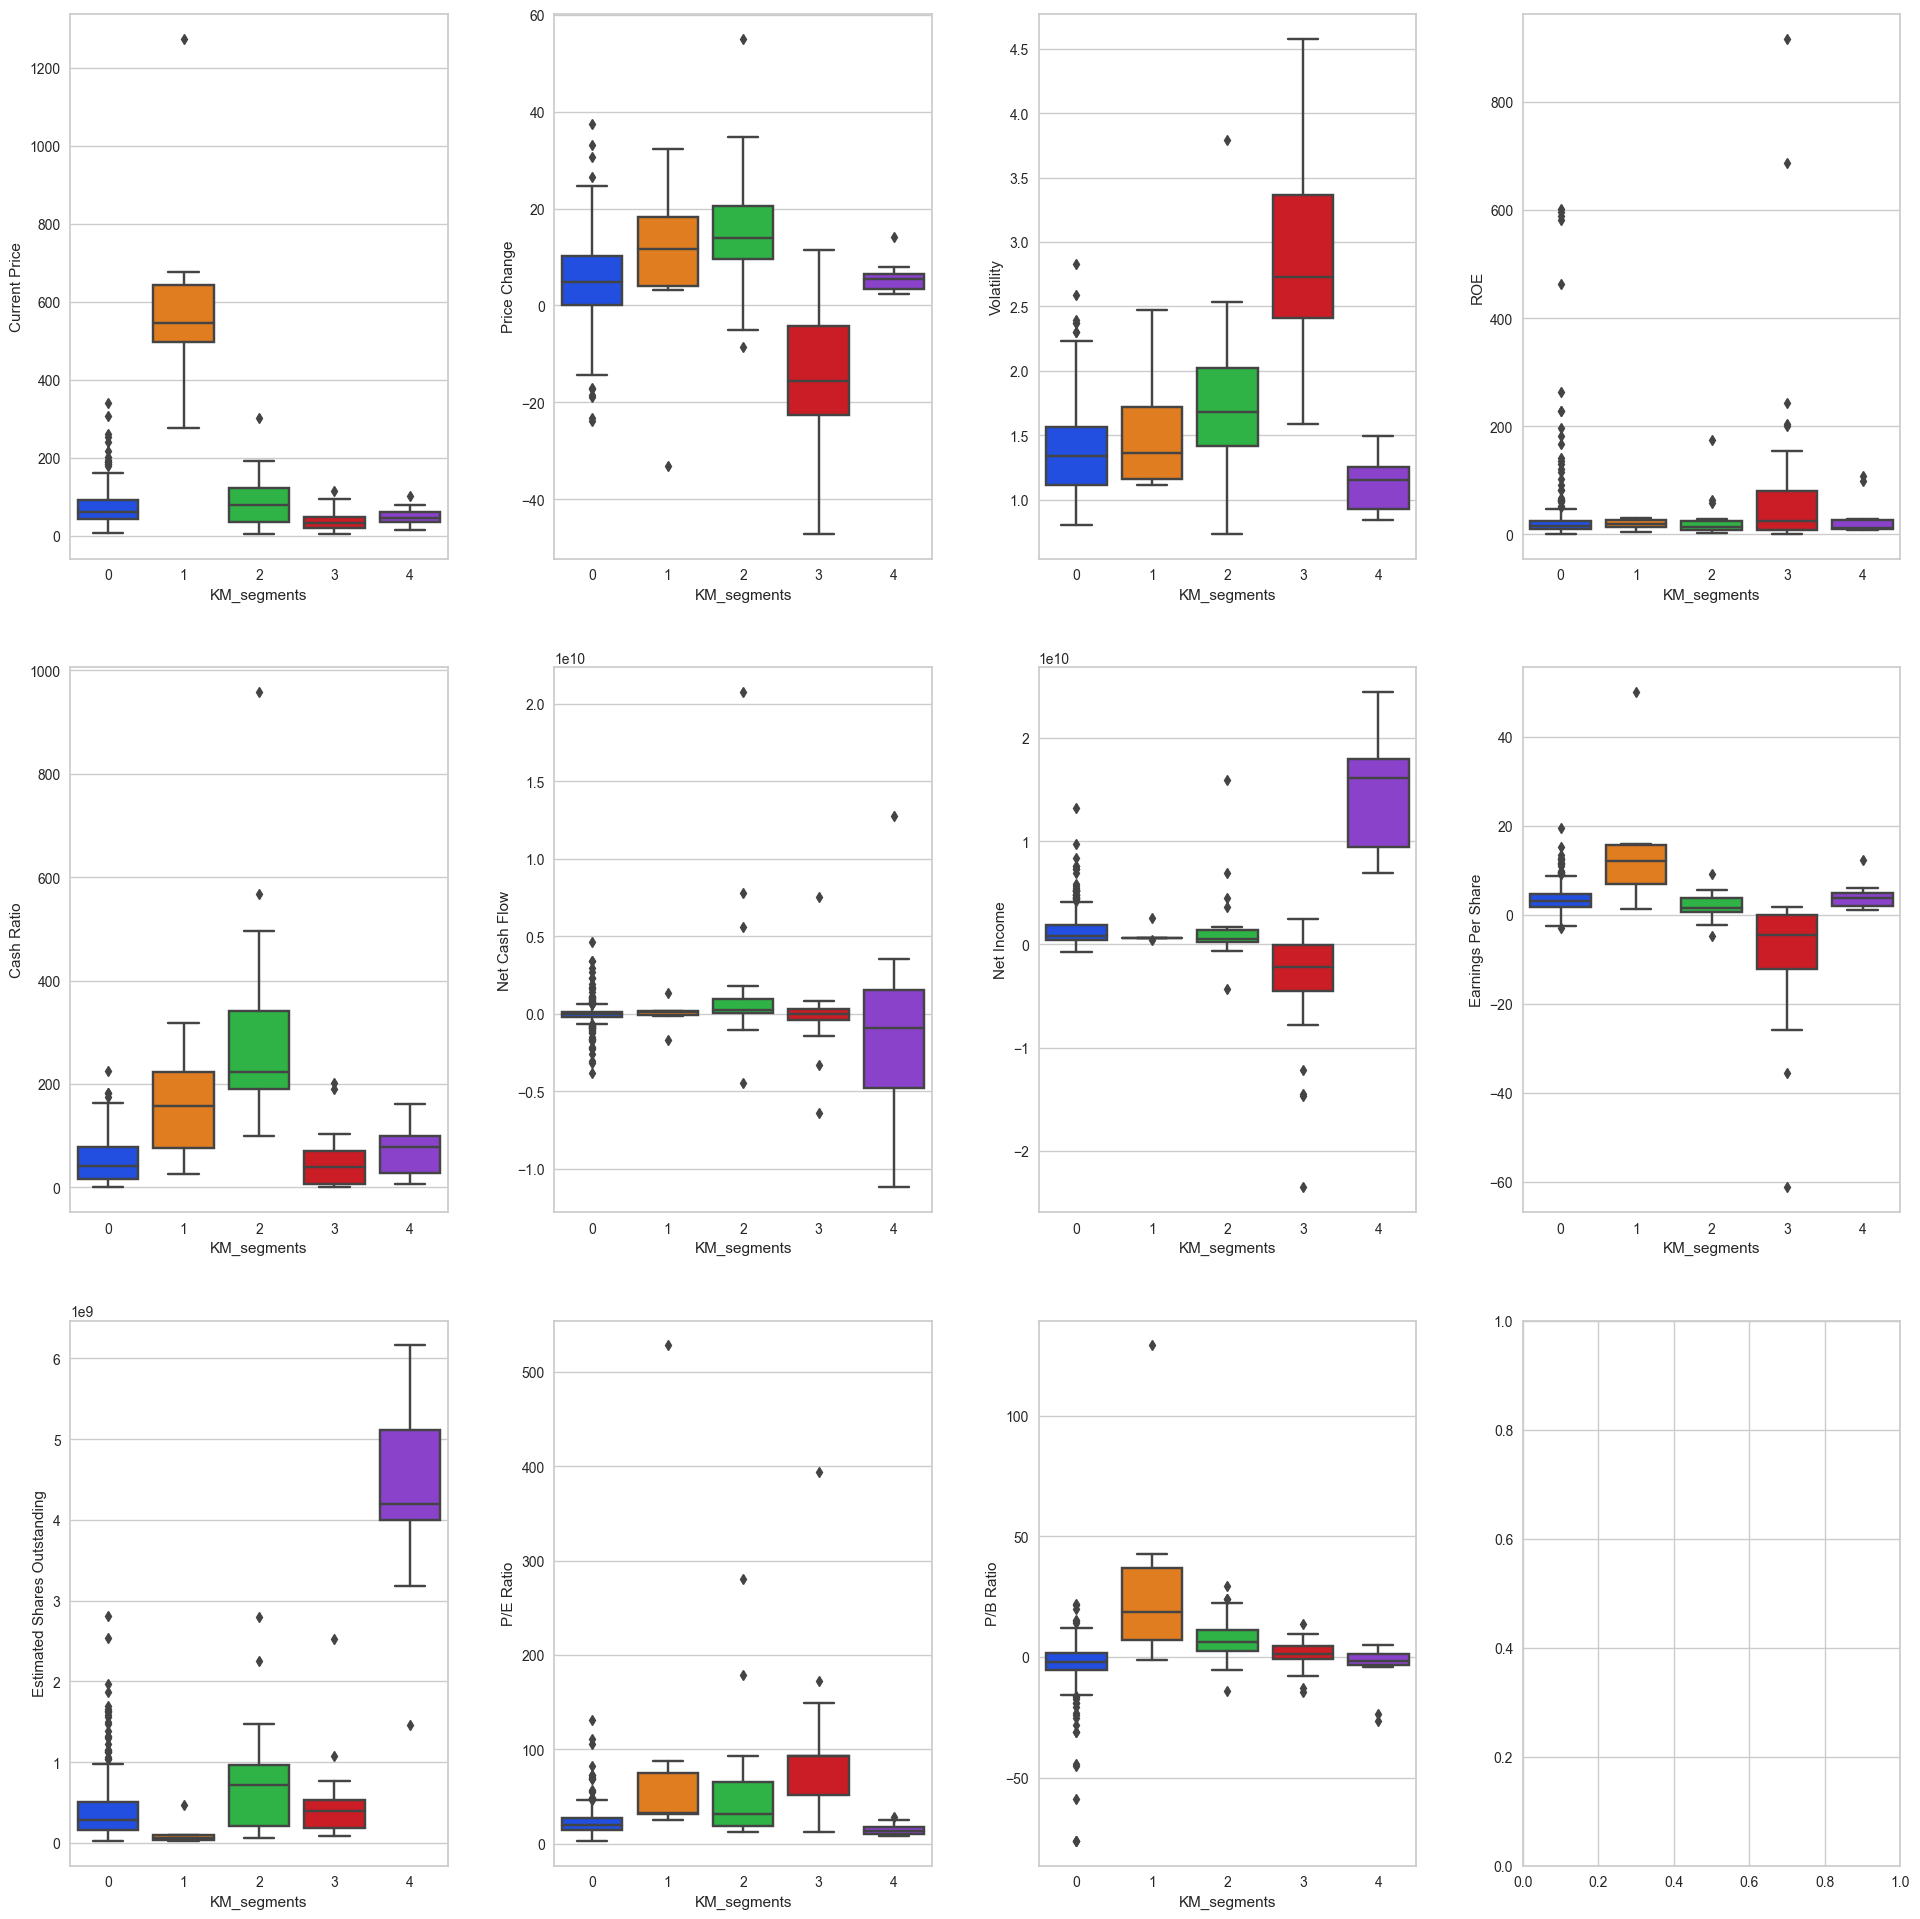

In [176]:
fig, axes = plt.subplots(3, 4, figsize=(20, 20))
store = 0

for j in range(3):
    for i in range(4):
        if store < 11:
            # Will generate a boxplot on the current subplot (axes[j][i])
            # Data is taken from 'td1'
            # The 'y' variable is selected dynamically based on 'store'
            # 'x' is set to "KM_segments" for all subplots
            # Use the "bright" color palette for the plot
            sns.boxplot(
                ax=axes[j][i],
                data=td1,
                y=td1.columns[3+store],
                x="KM_segments",
                palette="bright"
            )
            store = store + 1

fig.tight_layout(pad=3.0)

## Hierarchical Clustering

In [177]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(k_means_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(k_means_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, round(c,4)
            )
        )
        print(" ")
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.9436.
 
Cophenetic correlation for Euclidean distance and complete linkage is 0.8911.
 
Cophenetic correlation for Euclidean distance and average linkage is 0.9478.
 
Cophenetic correlation for Euclidean distance and weighted linkage is 0.771.
 
Cophenetic correlation for Chebyshev distance and single linkage is 0.9302.
 
Cophenetic correlation for Chebyshev distance and complete linkage is 0.7845.
 
Cophenetic correlation for Chebyshev distance and average linkage is 0.93.
 
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.9046.
 
Cophenetic correlation for Mahalanobis distance and single linkage is 0.9347.
 
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.8741.
 
Cophenetic correlation for Mahalanobis distance and average linkage is 0.9498.
 
Cophenetic correlation for Mahalanobis distance and weighted linkage is 0.9045.
 
Cophenetic correlation for Cityblock distanc

In [178]:
#will generate the combination of distance metric and linkage method with the maximum cophenetic correlation
print(
    "Maximum cophenetic correlation is {}, which is obtained with {} linkage.".format(
        round(high_cophenet_corr,4), high_dm_lm[1]))

Maximum cophenetic correlation is 0.9498, which is obtained with average linkage.


**Let's explore different linkage methods with Euclidean distance only.**

In [179]:
#List of linkage methods

linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(k_means_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(k_means_df))
    print(
            "Cophenetic correlation for Euclidean distance and {} linkage is {}.".format(
                lm, round(c,4)
            )
        )
    print(" ")
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.9436.
 
Cophenetic correlation for Euclidean distance and complete linkage is 0.8911.
 
Cophenetic correlation for Euclidean distance and average linkage is 0.9478.
 
Cophenetic correlation for Euclidean distance and centroid linkage is 0.9371.
 
Cophenetic correlation for Euclidean distance and ward linkage is 0.7478.
 
Cophenetic correlation for Euclidean distance and weighted linkage is 0.771.
 


**Let's view the dendrograms for the different linkage methods with Euclidean distance.**

### Checking Dendrograms

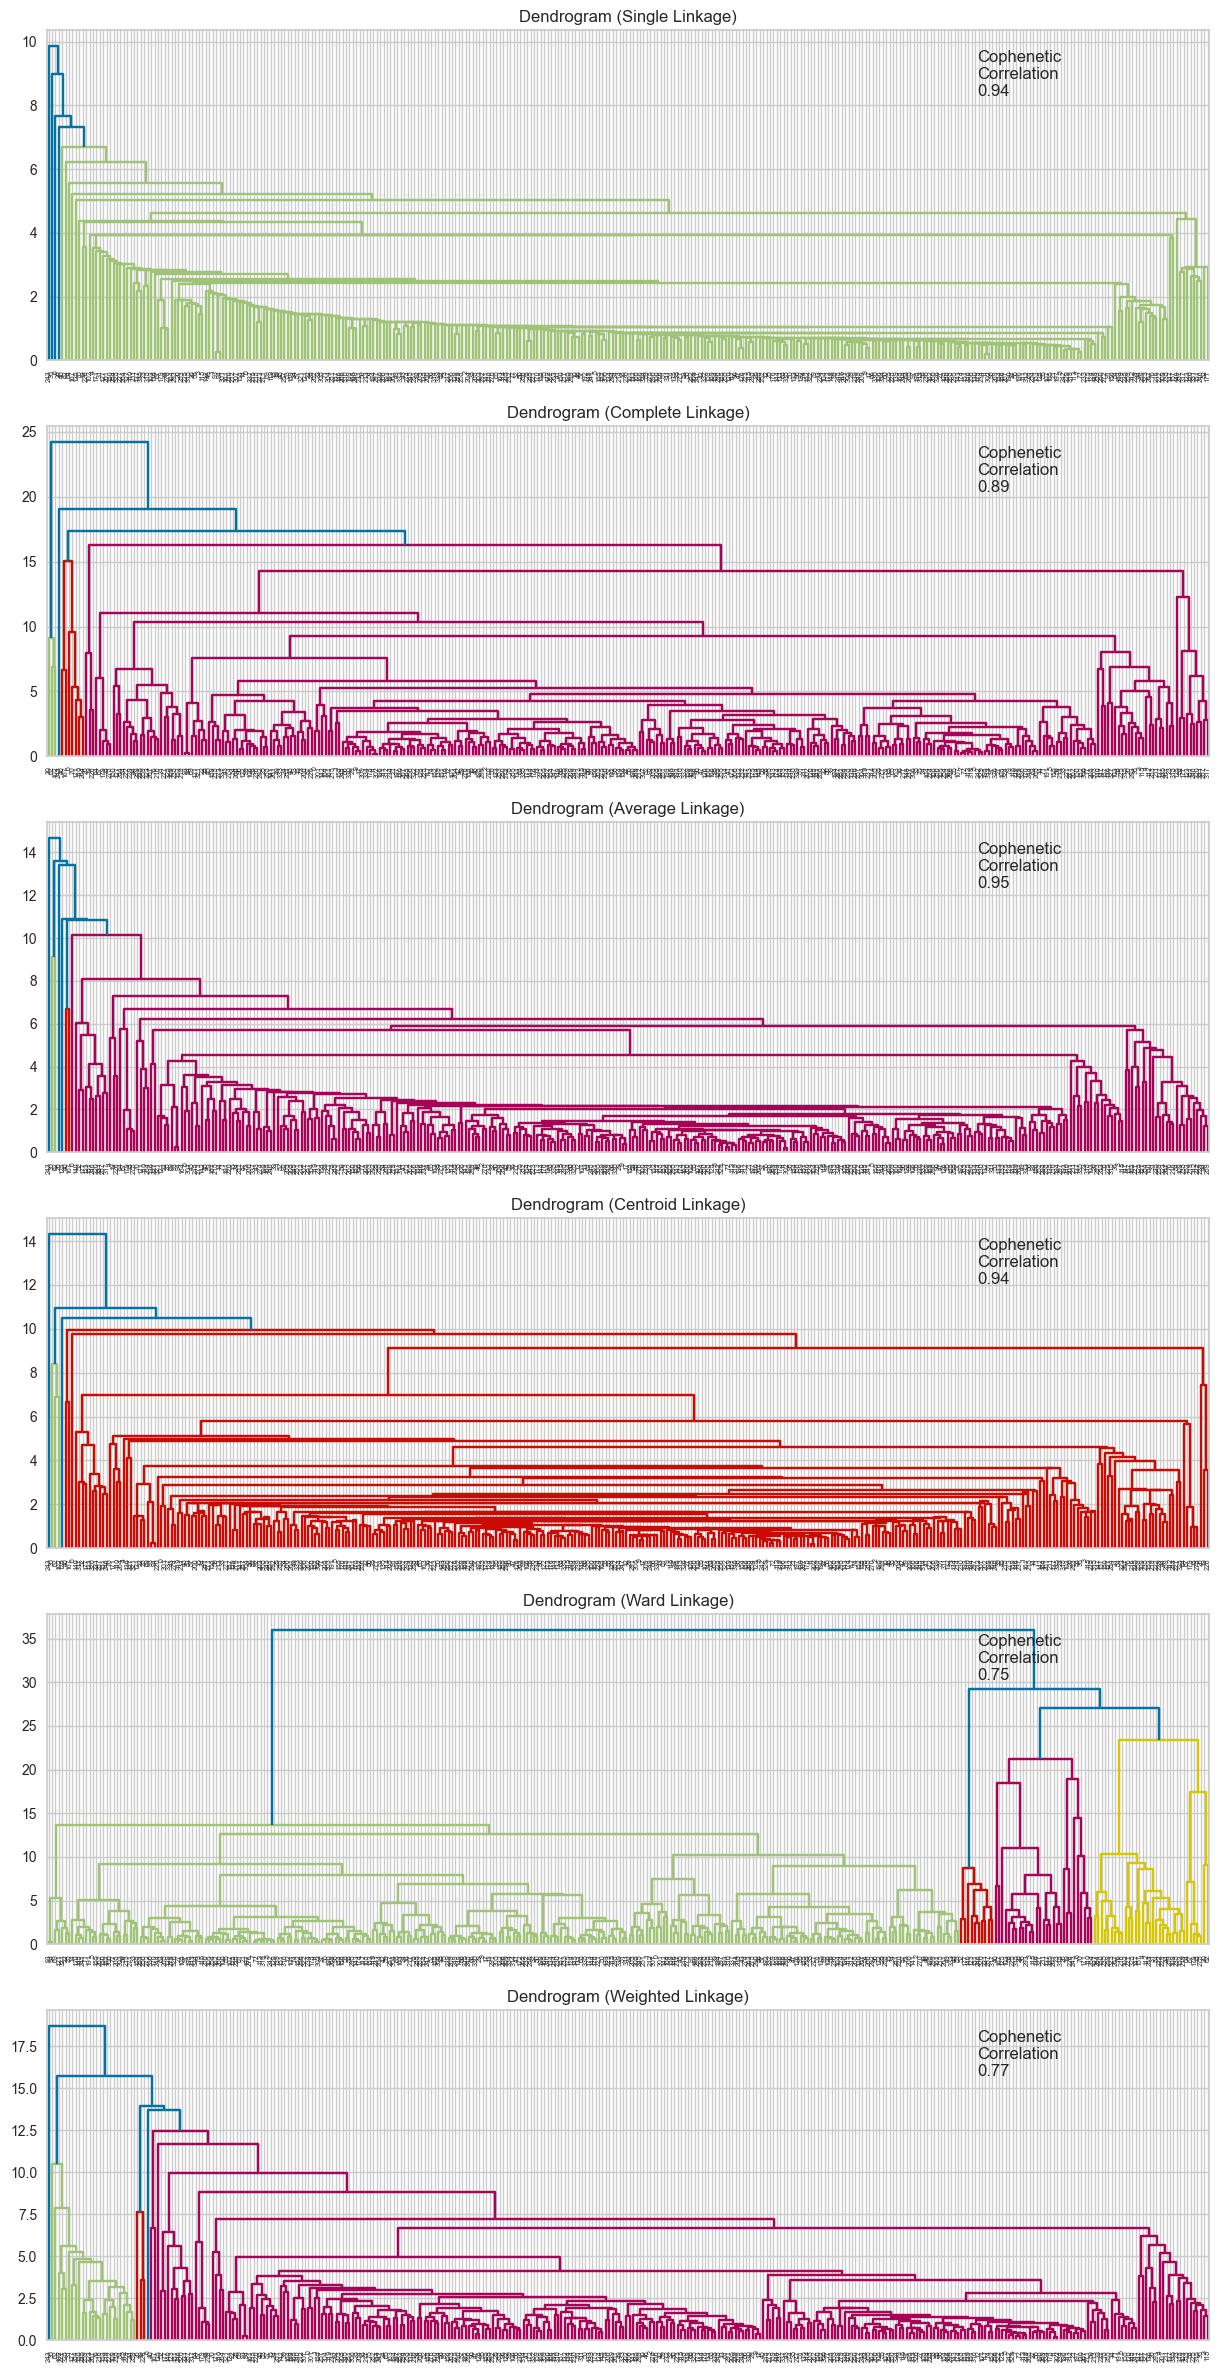

In [180]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare=[]
# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(k_means_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(k_means_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])



* These cophenetic correlation is the maximum for average and centroid linkage methods.

* We can see overall better clusters provided by dendogram.

* The cophenetic correlation for the Dendogram (weighted linkage) shows 77%

In [181]:
# Will generate a dataframe  dataframe to compare cophenetic correlations for different linkage methods
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc = df_cc.sort_values(by="Cophenetic Coefficient")
df_cc

,Linkage,Cophenetic Coefficient
4,ward,0.75
5,weighted,0.77
1,complete,0.89
3,centroid,0.94
0,single,0.94
2,average,0.95


In [182]:
Z = linkage(k_means_df, metric='euclidean', method='average')
c, coph_dists = cophenet(Z , pdist(k_means_df))

In [183]:
# Create an instance of the AgglomerativeClustering model with specified parameters:
hierarchy = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='average')

# Fit the AgglomerativeClustering model to the data in 'k_means_df'.
# This process will group the data points into clusters based on the specified parameters.
hierarchy.fit(k_means_df)


AgglomerativeClustering(affinity='euclidean', linkage='average', n_clusters=5)

* Cluster Profiling

In [184]:
# Create a copy of the DataFrame 'td1' and store it in the variable 'td_hierarchy'
td_hierarchy = td1.copy()

# Drop the column 'KM_segments' from the DataFrame 'td_hierarchy'
# The 'axis=1' argument specifies that we are dropping a column, and 'inplace=True' means the change is applied to the DataFrame itself
td_hierarchy.drop("KM_segments", axis=1, inplace=True)

# Add a new column 'HC_clusters' to the DataFrame 'td_hierarchy'
# The values for this column are assigned based on the cluster labels obtained from some hierarchical clustering object or model referred to as 'hierarchy'
td_hierarchy['HC_clusters'] = hierarchy.labels_


In [185]:
#group dataset by Hierarchical clusters
cluster_profile_td = td_hierarchy.groupby("HC_clusters").mean()

In [186]:
#add counts for number of stocks in each cluster
cluster_profile_td["Count"] = (
    td_hierarchy.groupby("HC_clusters")["Current Price"].count().values)

In [187]:
#show dataframe with maximum values for each metric highlighted
cluster_profile_td.style.highlight_max(color="lightgreen", axis=0)

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,Count
HC_clusters,,,,,,,,,,,,
0,75.787246,4.064498,1.515873,35.277612,67.182090,63325901.492537,1610410164.179105,2.910493,572636307.447164,30.845937,-1.779318,335
1,1274.949951,3.190527,1.268340,29.000000,184.000000,-1671386000.000000,2551360000.000000,50.090000,50935516.070000,25.453183,-1.052429,1
2,24.485001,-13.351992,3.482611,802.000000,51.000000,-1292500000.000000,-19106500000.000000,-41.815000,519573983.250000,60.748608,1.565141,2
3,675.890015,32.268105,1.460386,4.000000,58.000000,1333000000.000000,596000000.000000,1.280000,465625000.000000,528.039074,3.904430,1
4,104.660004,16.224320,1.320606,8.000000,958.000000,592000000.000000,3669000000.000000,1.310000,2800763359.000000,79.893133,5.884467,1


In [188]:
# Iterate through unique values in the 'HC_clusters' column
for cl in td_hierarchy["HC_clusters"].unique():
    # Print a header indicating the current cluster
    print("In cluster {}, the following companies are present:".format(cl))
    
    # Select unique company names within the current cluster and convert them to a list
    company_list = td_hierarchy[td_hierarchy["HC_clusters"] == cl]["Security"].unique().tolist()
    
    # Prints the list of companies in the current cluster
    print(company_list)
    
    # Prints an empty line for separation between clusters
    print()


In cluster 0, the following companies are present:
['American Airlines Group', 'AbbVie', 'Abbott Laboratories', 'Adobe Systems Inc', 'Analog Devices, Inc.', 'Archer-Daniels-Midland Co', 'Alliance Data Systems', 'Ameren Corp', 'American Electric Power', 'AFLAC Inc', 'American International Group, Inc.', 'Apartment Investment & Mgmt', 'Assurant Inc', 'Arthur J. Gallagher & Co.', 'Akamai Technologies Inc', 'Albemarle Corp', 'Alaska Air Group Inc', 'Allstate Corp', 'Allegion', 'Alexion Pharmaceuticals', 'Applied Materials Inc', 'AMETEK Inc', 'Affiliated Managers Group Inc', 'Amgen Inc', 'Ameriprise Financial', 'American Tower Corp A', 'AutoNation Inc', 'Anthem Inc.', 'Aon plc', 'Anadarko Petroleum Corp', 'Amphenol Corp', 'Arconic Inc', 'Activision Blizzard', 'AvalonBay Communities, Inc.', 'Broadcom', 'American Water Works Company Inc', 'American Express Co', 'Boeing Company', 'Bank of America Corp', 'Baxter International Inc.', 'BB&T Corporation', 'Bard (C.R.) Inc.', 'Baker Hughes Inc', 'B

In [189]:
# Loop through the range of unique values in the 'HC_clusters' column
for k in range(0, td_hierarchy['HC_clusters'].nunique()):
    # Prints a header indicating the current cluster
    print('The number of stocks within each GICS Sector for Cluster ' + str(k) + ' are:')
    
    # Calculate and print the count of stocks in each GICS Sector for the current cluster
    print(td_hierarchy[td_hierarchy['HC_clusters'] == k]['GICS Sector'].value_counts())
    
    # Prints an empty line for separation between clusters
    print("   ")


The number of stocks within each GICS Sector for Cluster 0 are:
Industrials                    53
Financials                     49
Health Care                    40
Consumer Discretionary         38
Information Technology         32
Energy                         28
Real Estate                    27
Utilities                      24
Materials                      20
Consumer Staples               19
Telecommunications Services     5
Name: GICS Sector, dtype: int64
   
The number of stocks within each GICS Sector for Cluster 1 are:
Consumer Discretionary         1
Consumer Staples               0
Energy                         0
Financials                     0
Health Care                    0
Industrials                    0
Information Technology         0
Materials                      0
Real Estate                    0
Telecommunications Services    0
Utilities                      0
Name: GICS Sector, dtype: int64
   
The number of stocks within each GICS Sector for Cluster 2 are:

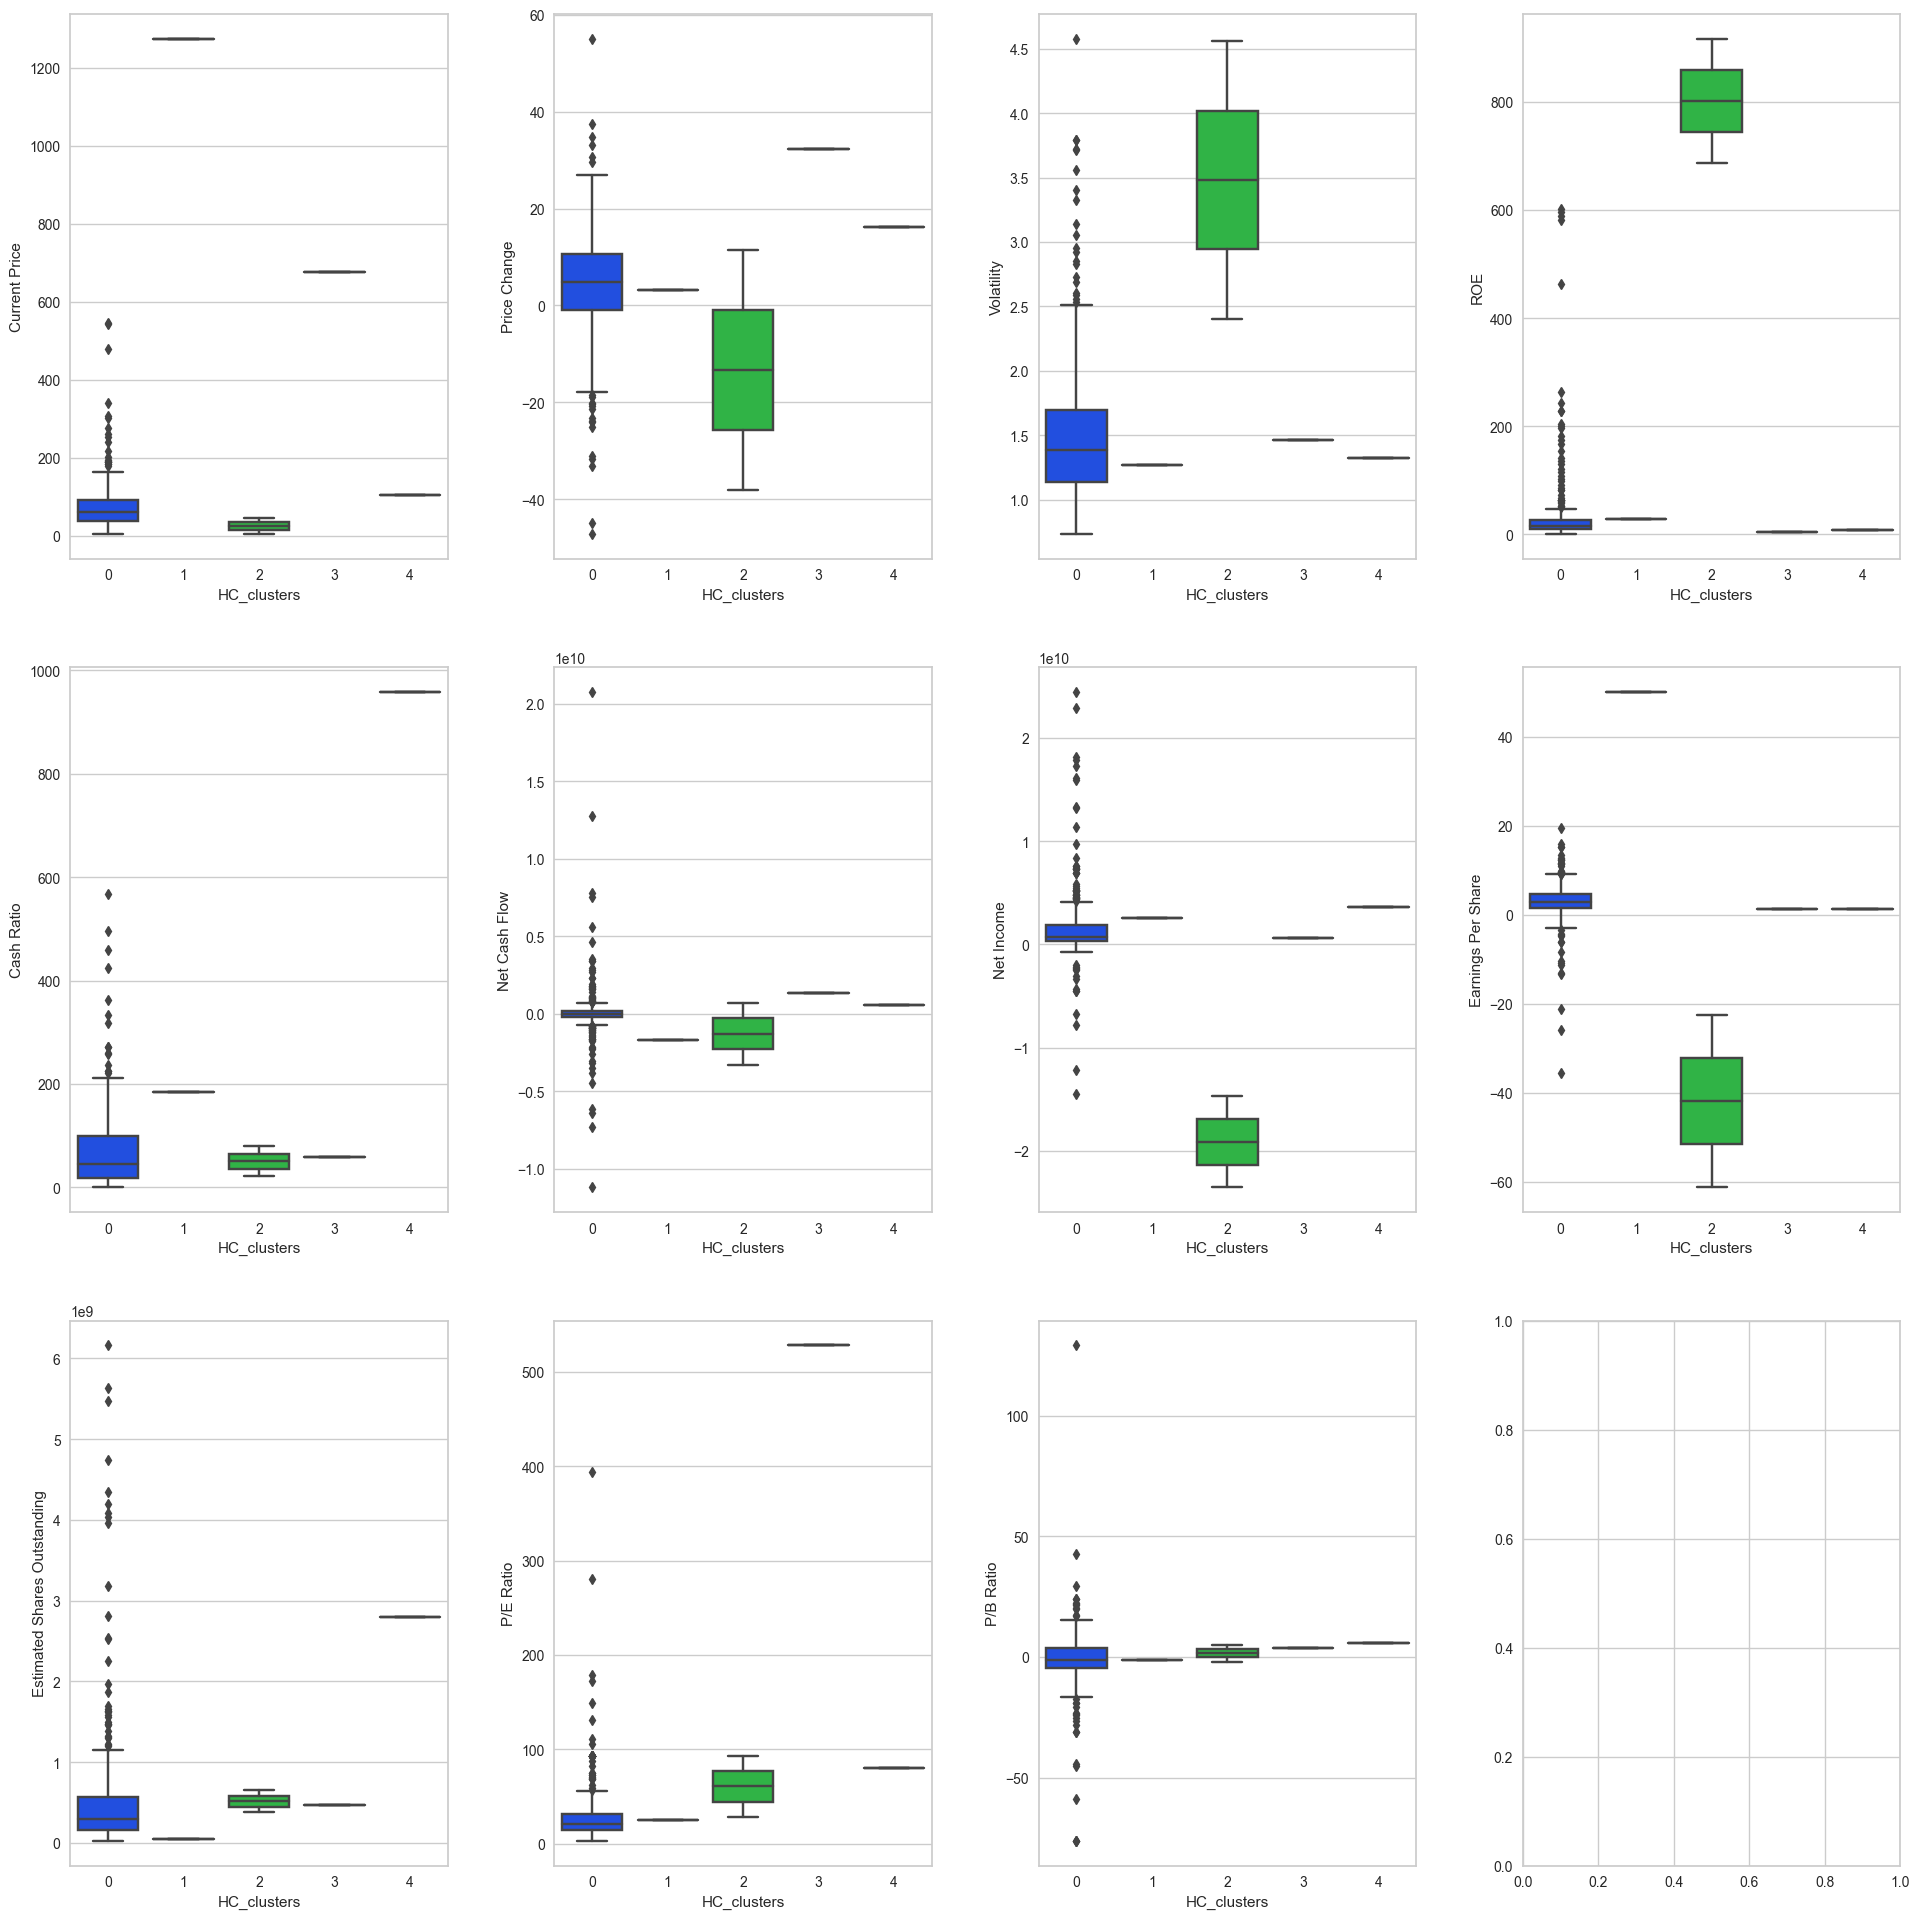

In [190]:


# Create a 3x4 grid of subplots with a specified figure size
fig, axes = plt.subplots(3, 4, figsize=(20, 20))

# Initialize a variable to keep track of the current plot
store = 0

# Loop through rows (j) and columns (i) of the grid
for j in range(3):
    for i in range(4):
        # Check if we haven't used all the columns (up to 11)
        if store < 11:
            # Create a boxplot on the current subplot (axes[j][i])
            # Data is taken from 'td_hierarchy'
            # The 'y' variable is selected dynamically based on 'store'
            # 'x' is set to "HC_clusters" for all subplots
            # Use the "bright" color palette for the plot
            sns.boxplot(
                ax=axes[j][i],
                data=td_hierarchy,
                y=td_hierarchy.columns[3 + store],
                x="HC_clusters",
                palette="bright"
            )
            # Increment the 'store' variable to move to the next column
            store = store + 1

# Adjust the layout of the subplots with some padding
fig.tight_layout(pad=3.0)

# Display the resulting plot
plt.show()


## K-means vs Hierarchical Clustering

You compare several things, like:
- Which clustering technique took less time for execution?

All the clustering methods was fast enough overall but, Agglomerative clustering was the fastest.

- How many clusters are obtained as the appropriate number of clusters from both algorithms?

We have seen that how 5 clusters naturally implied distinct clusters and gave us diversified option to choose the representative of the cluster.

## Actionable Insights and Recommendations

- Trade&Ahead may opt to utilize these clusters as an initial reference for conducting more in-depth analysis of financial statements, with a particular focus on identifying individual stocks that deviate from the cluster's established characteristics.

- If a client's investment strategy involves handpicking individual stocks, Trade&Ahead could potentially spot stocks expected to outperform their counterparts (leading to buy recommendations) or those likely to underperform (resulting in sell recommendations).
